<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from string import ascii_letters
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import imblearn
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,  accuracy_score

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
house.head()
print(house.shape)

(1460, 81)


**Remove all non-residential Entries within our dataset**
**These include: 65 FV, 10 C**

In [3]:
print(house['MSZoning'].value_counts())
print('#Columns', house.shape)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
#Columns (1460, 81)


In [4]:
res_homes = house[~house['MSZoning'].isin(['FV','C (all)'])]
res_homes.reset_index(drop=True, inplace = True)

#Verify they were removed
print(res_homes['MSZoning'].value_counts())
print('#Columns', res_homes.shape)

RL    1151
RM     218
RH      16
Name: MSZoning, dtype: int64
#Columns (1385, 81)


## Identifying Missing Values

**Most of the Missing Values are from Renovatable Features, except for LotFrontage. These will be dealth with in section 2.**

**Section 1: Replace LotFrontage by the mean LotFrontage for the neighborhood.**

In [5]:
a = (res_homes.isnull().sum()/len(res_homes))*100
missing_values = pd.DataFrame({'%  Missing Data' : a})
missing_values[missing_values['%  Missing Data'].between(0,100, inclusive = False)].sort_values(by = '%  Missing Data', ascending = False)

%  Missing Data
PoolQC              99.494585
MiscFeature         96.245487
Alley               95.306859
Fence               80.000000
FireplaceQu         46.281588
LotFrontage         18.122744
GarageType           5.703971
GarageYrBlt          5.703971
GarageFinish         5.703971
GarageQual           5.703971
GarageCond           5.703971
BsmtExposure         2.743682
BsmtFinType2         2.743682
BsmtFinType1         2.671480
BsmtCond             2.671480
BsmtQual             2.671480
MasVnrArea           0.361011
MasVnrType           0.361011
Electrical           0.072202

## Distribution of Sale Prices

C:\Users\pasca\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Home Sale Prices')

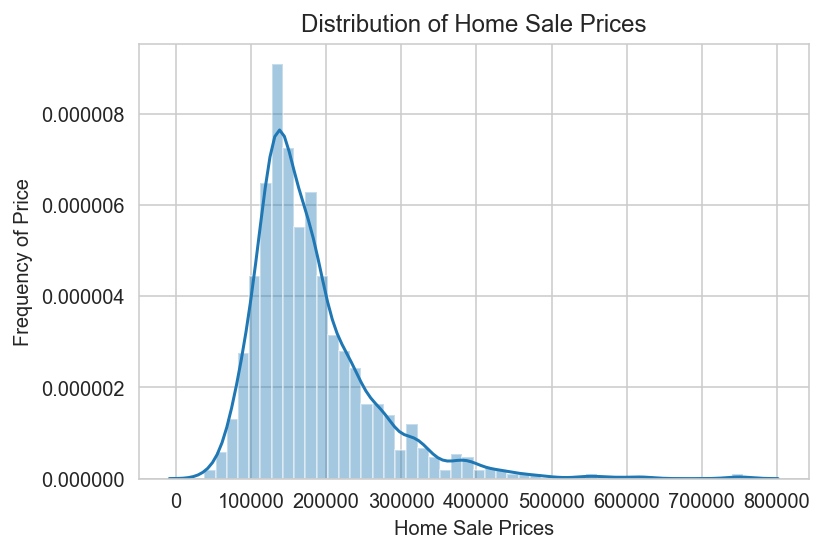

In [6]:
sns.distplot(np.array(res_homes['SalePrice']))
plt.title('Distribution of Home Sale Prices')
plt.ylabel('Frequency of Price')
plt.xlabel('Home Sale Prices')

**Note: The Sale price distribution is skewed. For the purpose of extracting dollar values from coefficients, the Sale Price was not changed to log transformed values.**

## Sale Price Per Year.

The dataset contains 5 years of housing sales data. 

The Median sale price for 2010 is lower than the other years, and we can see that prices seem to be deceasing with time. This may be due to the financial situation in 2008-2009. 

In 2007, we observe two outliers. 


In [7]:
res_homes.groupby(['YrSold'])[['SalePrice']].agg(['mean', 'std', 'median', 'min', 'max'])

SalePrice                                     
                 mean           std  median    min     max
YrSold                                                    
2006    183136.846154  80544.824801  162900  52500  625000
2007    184686.980831  86816.831557  163500  39300  755000
2008    176048.663194  69185.412509  162700  52000  446261
2009    177754.426791  80757.054767  159434  37900  582933
2010    177820.878049  81196.031764  154650  55000  611657

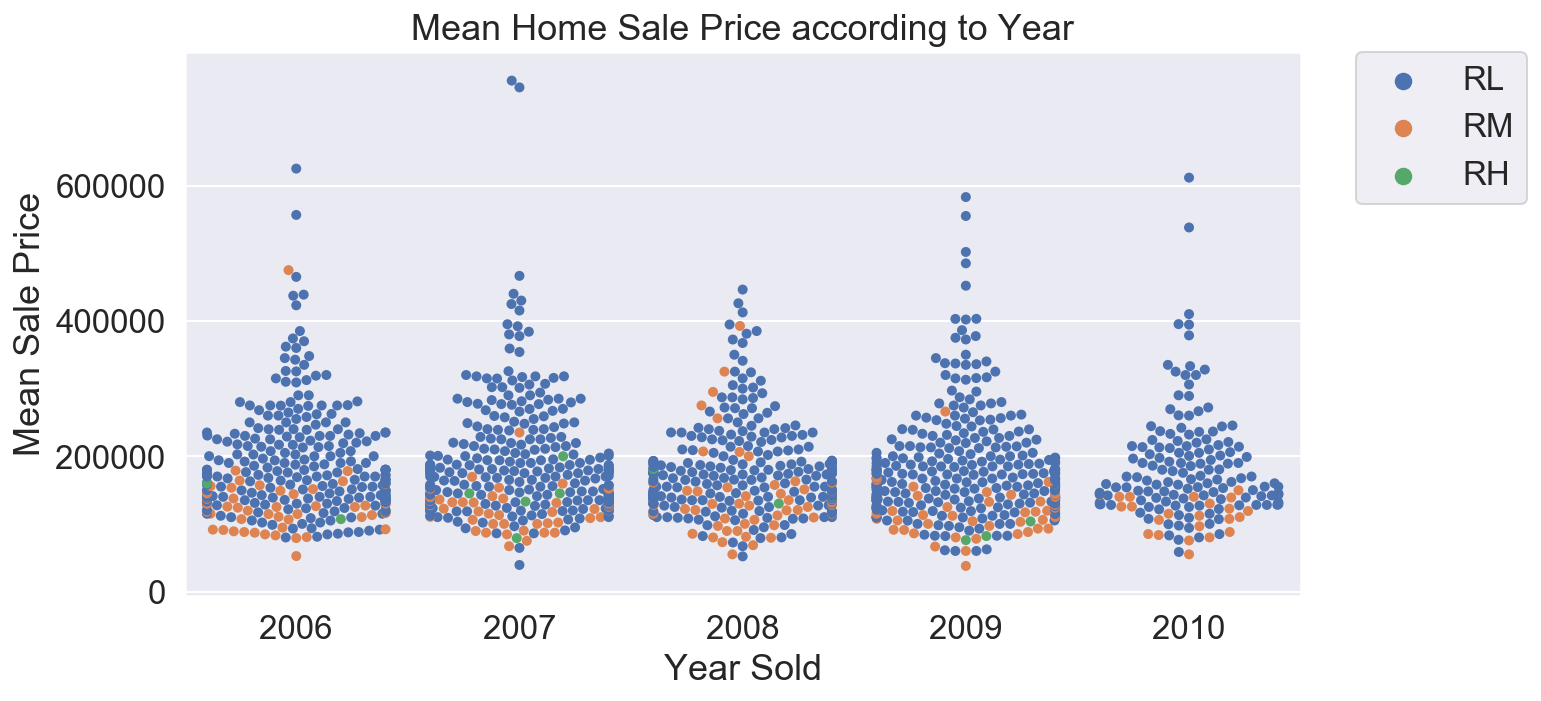

In [8]:
sns.set(rc={'figure.figsize': (10,5)}, font_scale= 1.5)
sns.swarmplot(x = 'YrSold', y = 'SalePrice', data = res_homes, hue = 'MSZoning')
plt.title('Mean Home Sale Price according to Year')
plt.ylabel('Mean Sale Price')
plt.xlabel('Year Sold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [9]:
# Remove 2007 outliers
res_homes = res_homes[res_homes['SalePrice'] < 650000]

## Visualization of Fixed Features

### Neighborhood 
- Physical locations within Ames city limits 

**Observation :** House prices seem to with the neighborhood. 

**Verdict :** Keep feature for model

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

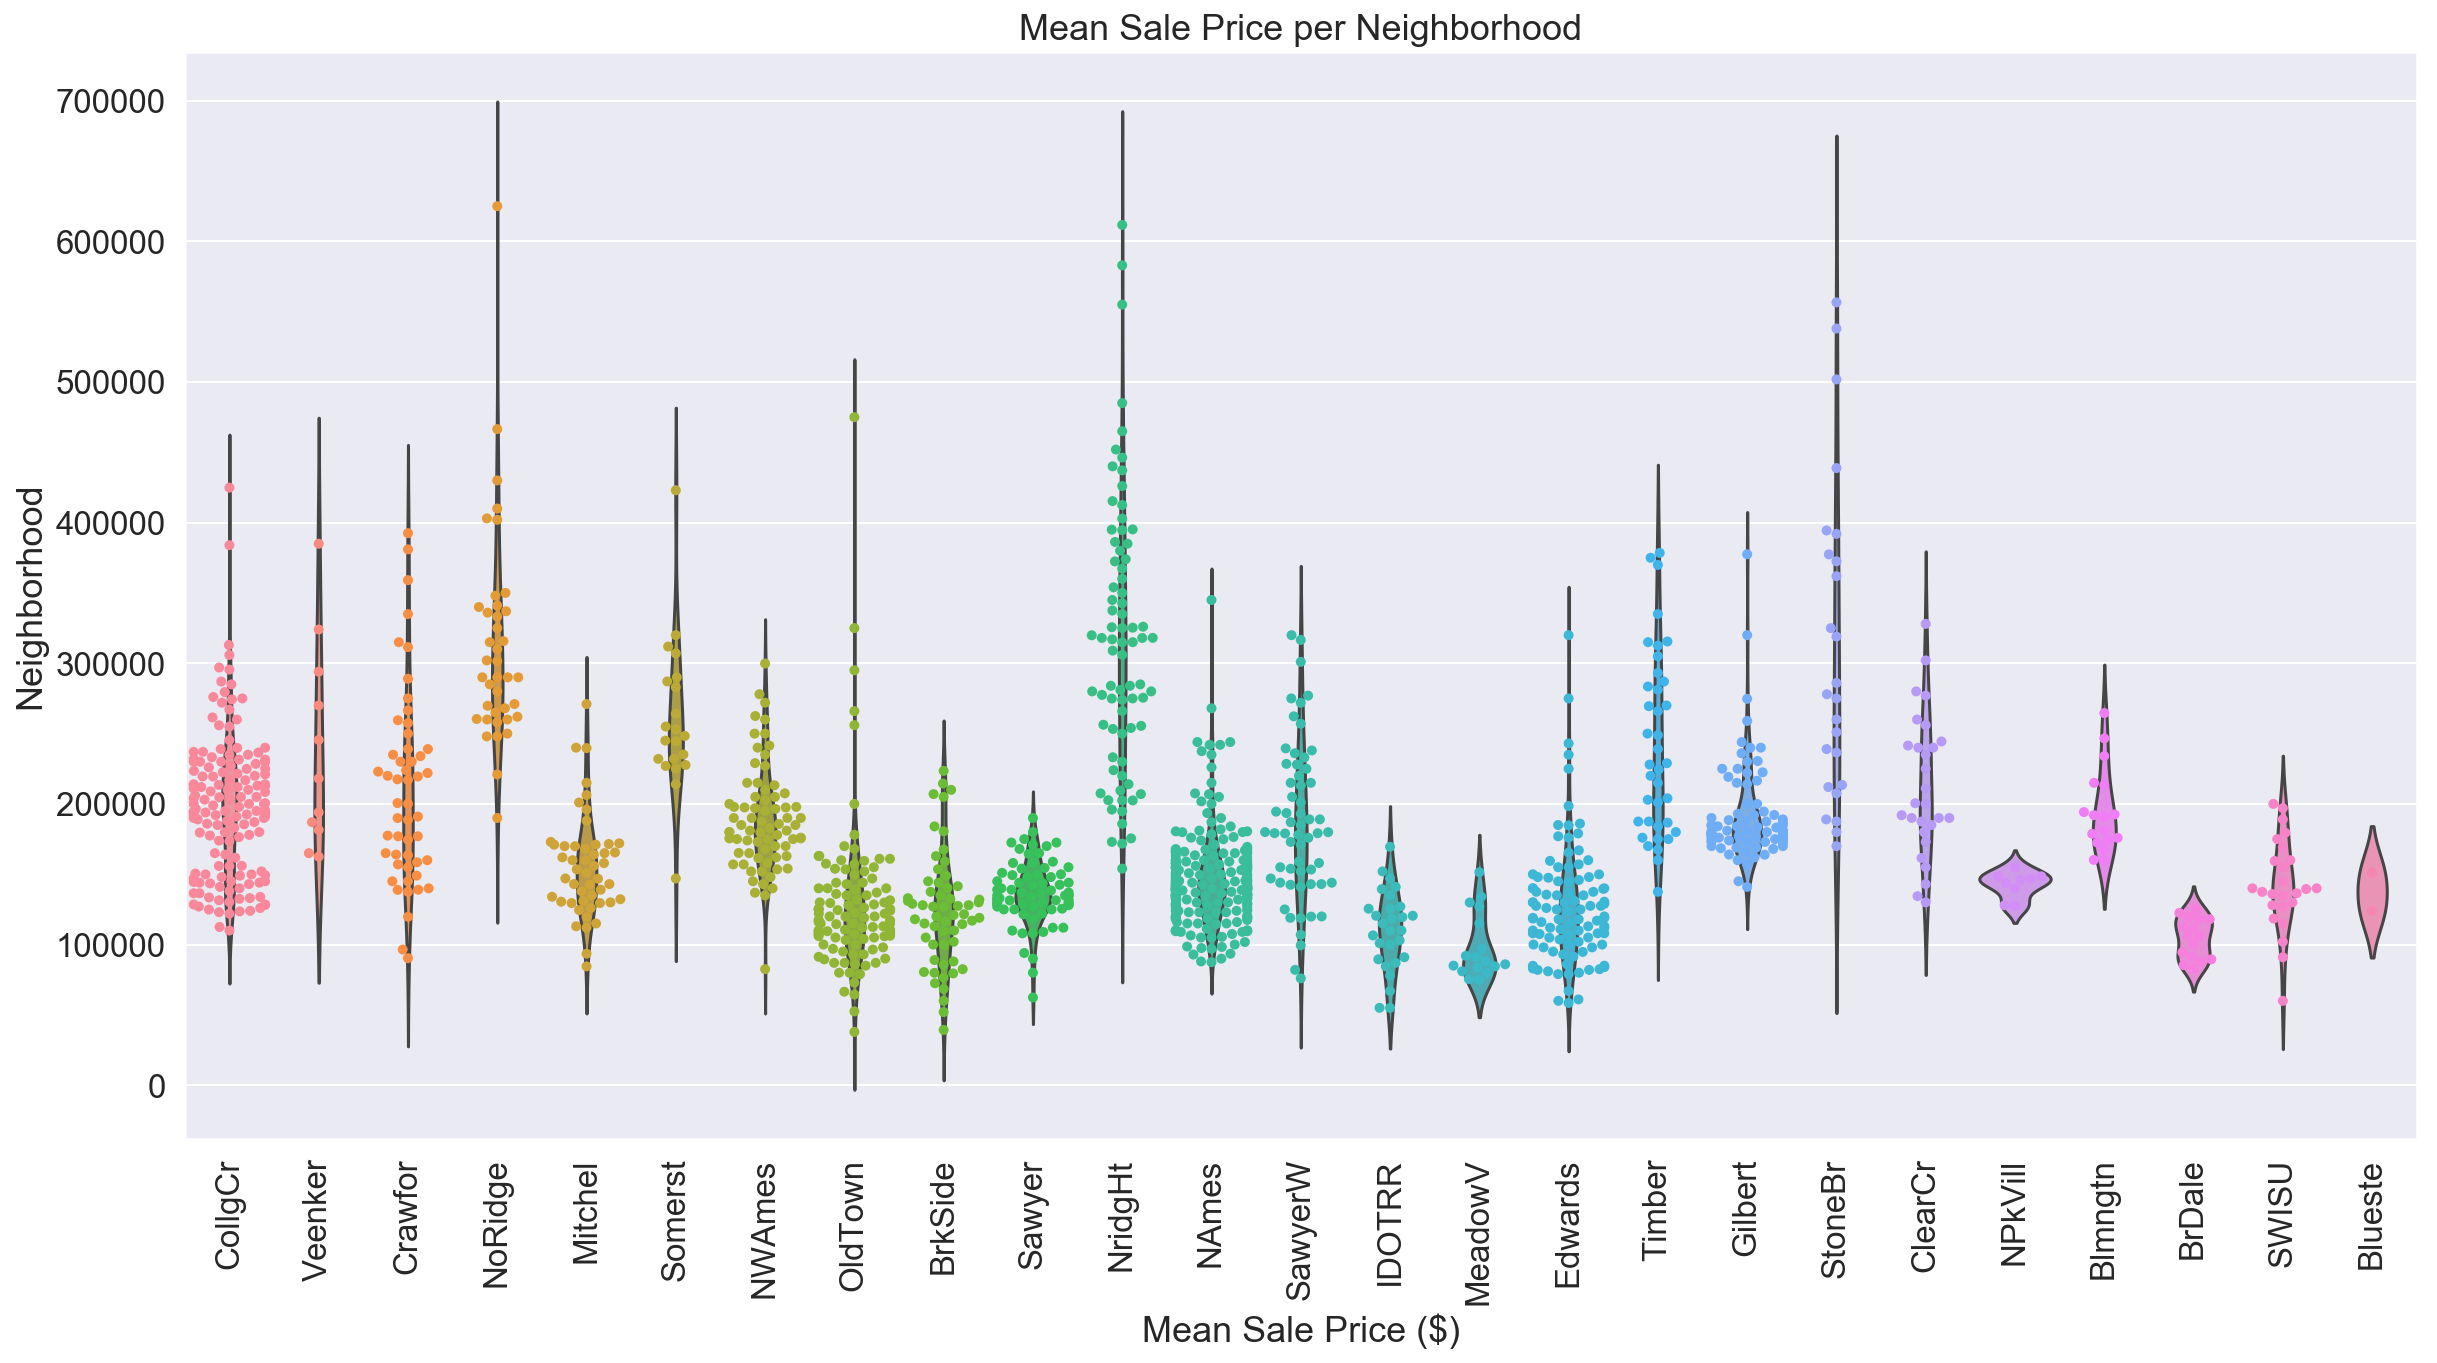

In [10]:
sns.set(rc={'figure.figsize': (20,10)}, font_scale= 1.5)

ax = sns.violinplot(x = 'Neighborhood', y = 'SalePrice', data = res_homes, inner=None)
ax = sns.swarmplot(x = 'Neighborhood', y = 'SalePrice', data = res_homes)

plt.xlabel('Mean Sale Price ($)')
plt.ylabel('Neighborhood')
plt.title('Mean Sale Price per Neighborhood')
plt.xticks(rotation = 90)

### MSSubClass (Type of Dwelling involved in the sale):

- 20 -> 1-STORY 1946 & NEWER ALL STYLES
- 30 -> 1-STORY 1945 & OLDER
- 40 -> 1-STORY W/FINISHED ATTIC ALL AGES
- 45 -> 1-1/2 STORY - UNFINISHED ALL AGES
- 50 -> 1-1/2 STORY FINISHED ALL AGES
- 60 -> 2-STORY 1946 & NEWER
- 70 -> 2-STORY 1945 & OLDER
- 75 -> 2-1/2 STORY ALL AGES
- 80 -> SPLIT OR MULTI-LEVEL
- 85 -> SPLIT FOYER
- 90 -> DUPLEX - ALL STYLES AND AGES
- 120 -> 1-STORY PUD (Planned Unit Development) - 1946 & NEWER
- 150 -> 1-1/2 STORY PUD - ALL AGES
- 160 -> 2-STORY PUD - 1946 & NEWER
- 180 -> PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
- 190 -> 2 FAMILY CONVERSION - ALL STYLES AND AGES

**Feature Engineering :** Change from Int to String. 

**Observation :** House prices seem to change with the type of home sold. E.g 2-Story houses that were built after 1946, seem to sell for more. 

Text(0.5, 1.0, 'Mean Sale Price according to MSSubClass')

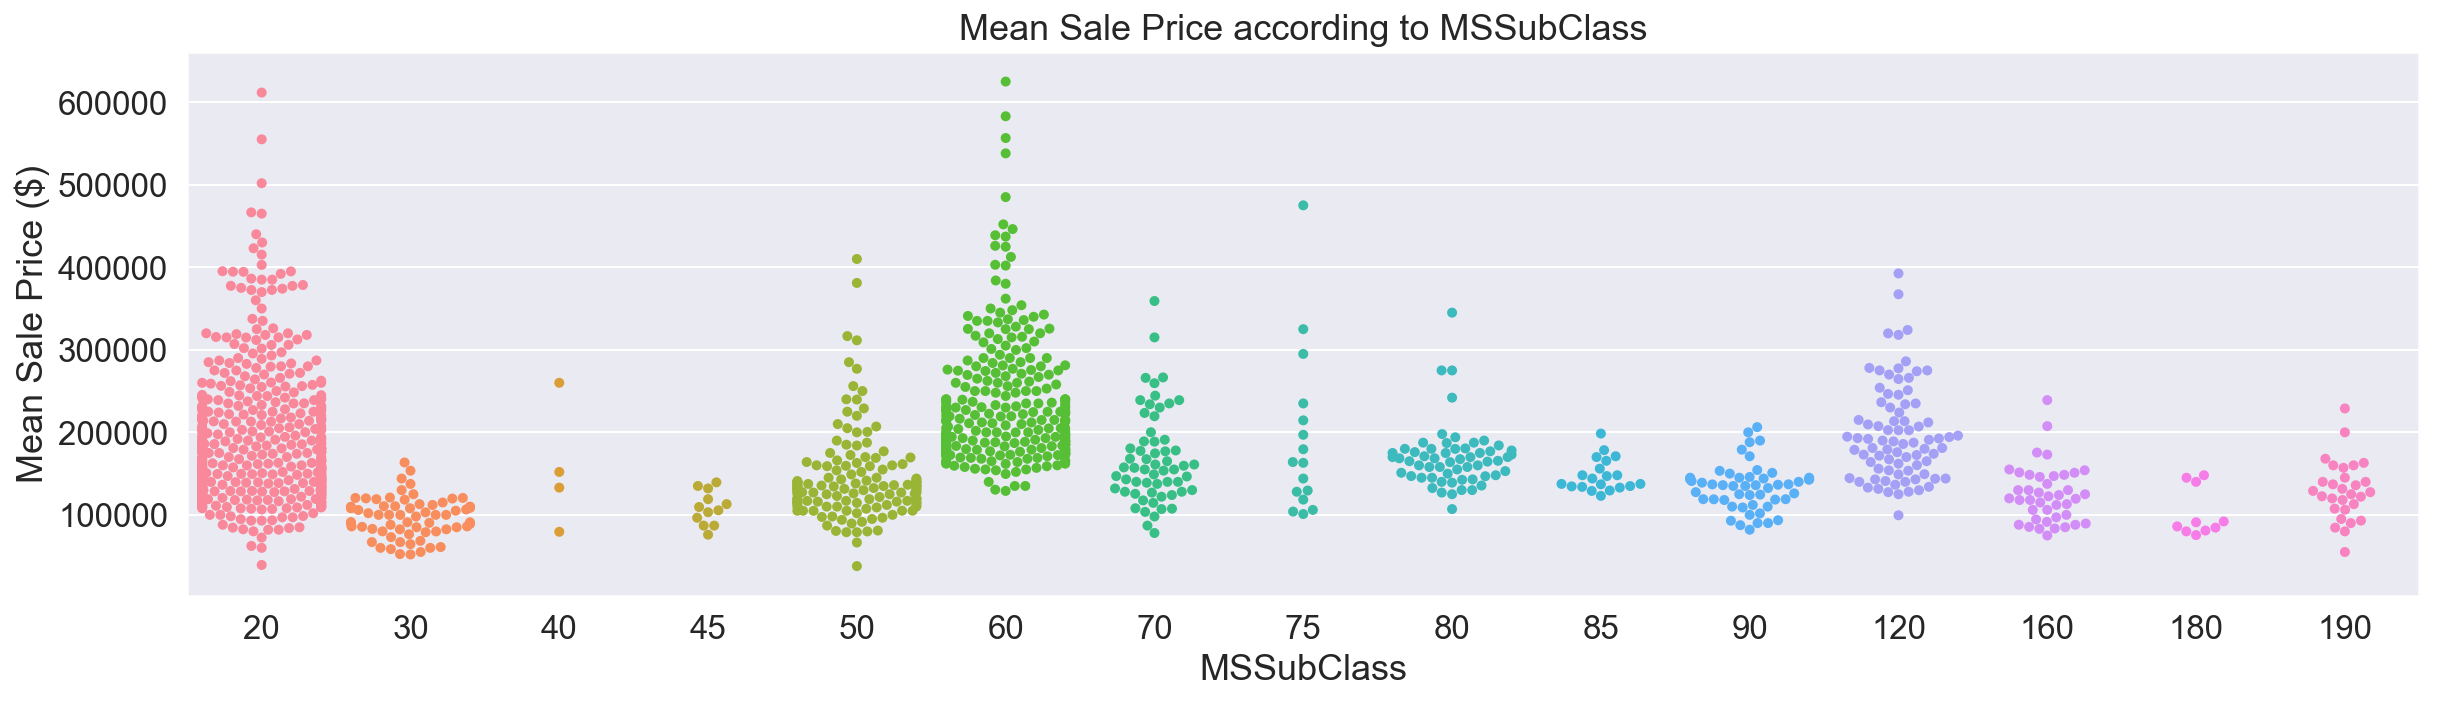

In [11]:
sns.set(rc={'figure.figsize': (20,5)}, font_scale=1.5)
sns.swarmplot(x = 'MSSubClass', y = 'SalePrice', data = res_homes)
plt.ylabel('Mean Sale Price ($)')
plt.xlabel('MSSubClass')
plt.title('Mean Sale Price according to MSSubClass')

In [12]:
# Integers to Object
res_homes['MSSubClass']=res_homes['MSSubClass'].apply(str)

### MSZoning : 
- RH -> Residential Home
- RL -> Residential Low Density
- RM -> Residential Medium Density

**Observation :** The majority of the houses are Low Density Homes. Other homes seem to sell for less. 

Text(0.5, 1.0, 'Mean Sale Price according to MSZoning')

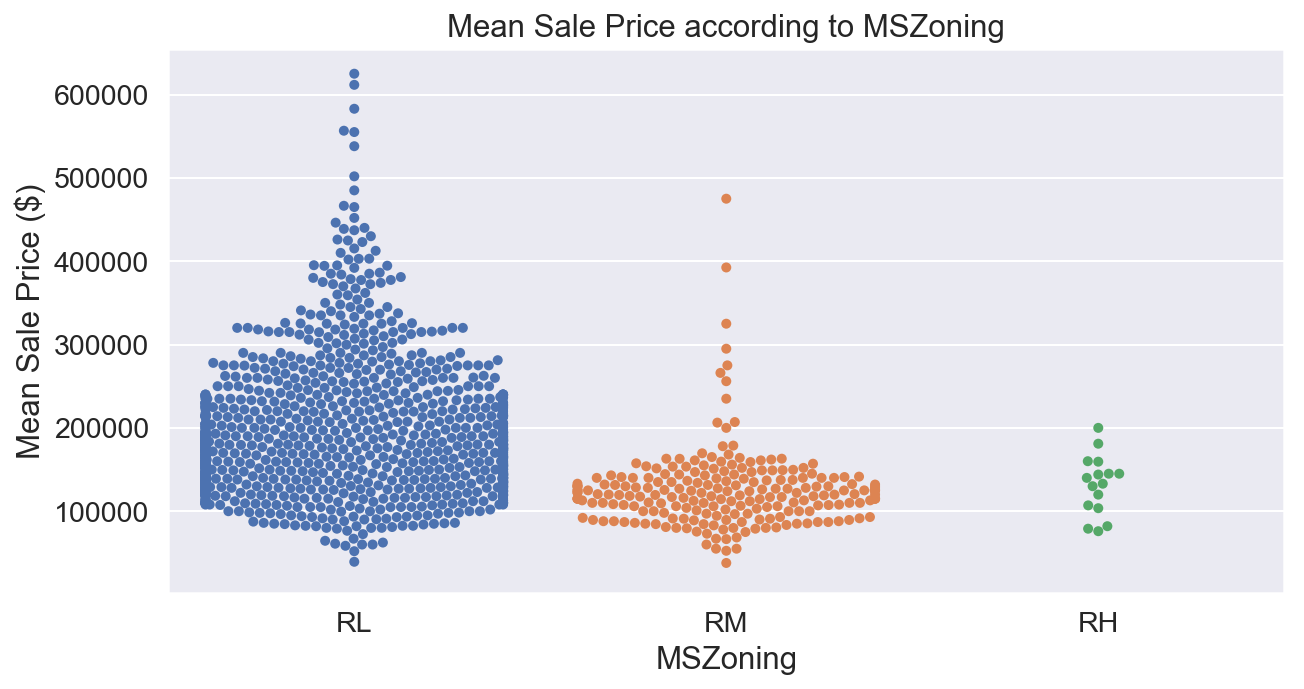

In [12]:
sns.set(rc={'figure.figsize': (10,5)}, font_scale=1.3)
sns.swarmplot(x = 'MSZoning', y = 'SalePrice', data = res_homes)
plt.ylabel('Mean Sale Price ($)')
plt.xlabel('MSZoning')
plt.title('Mean Sale Price according to MSZoning')

### BldgType :
- 1Fam -> Single-family Detached
- 2FmCon -> Two-family Conversion; originally built as one-family dwelling
- Duplx -> Duplex
- TwnhsE -> Townhouse End Unit
- TwnhsI -> Townhouse Inside Unit

**Observation :** The majority of the houses are 1 Family homes. Other homes seem to sell for less (eg. Two-Family Conversion)

Text(0.5, 1.0, 'Mean Sale Price according to Building Type')

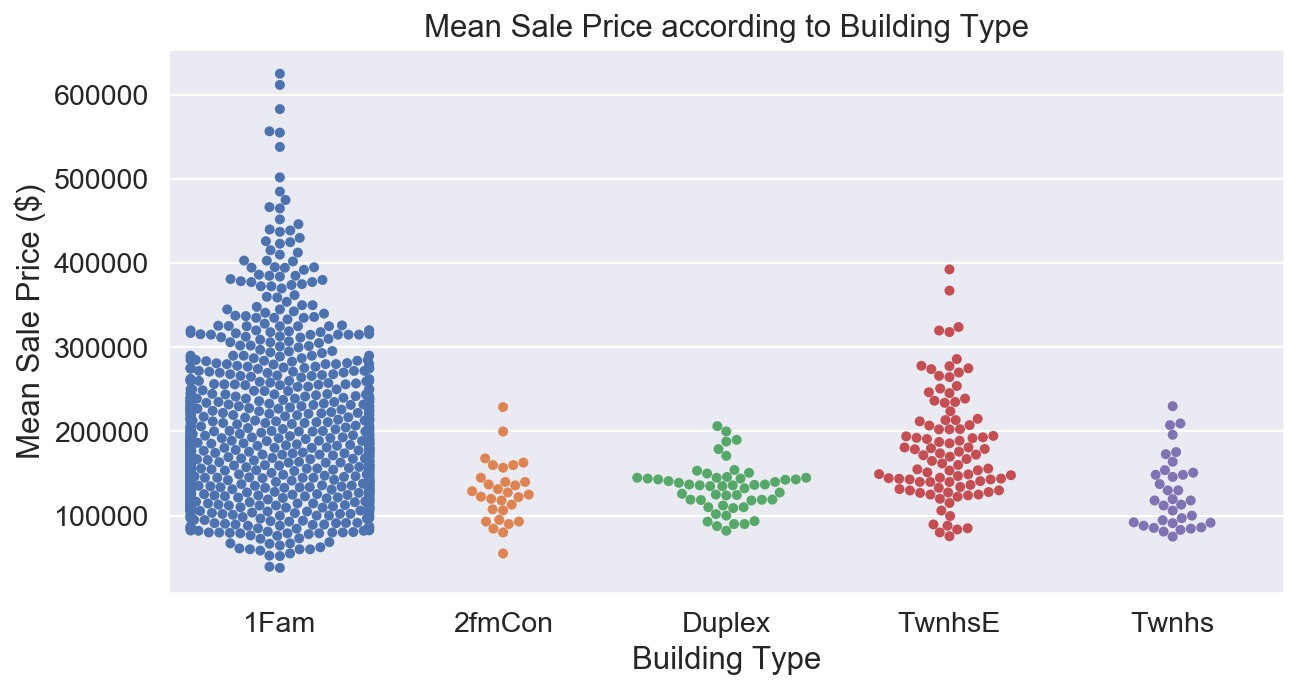

In [13]:
sns.set(rc={'figure.figsize': (10,5)}, font_scale=1.3)
sns.swarmplot(x = 'BldgType', y = 'SalePrice', data = res_homes)
plt.ylabel('Mean Sale Price ($)')
plt.xlabel('Building Type')
plt.title('Mean Sale Price according to Building Type')

### HouseStyle : 
- 1Story -> One story
- 1.5Fin -> One and one-half story: 2nd level finished
- 1.5Unf -> One and one-half story: 2nd level unfinished
- 2Story -> Two story
- 2.5Fin -> Two and one-half story: 2nd level finished
- 2.5Unf -> Two and one-half story: 2nd level unfinished
- SFoyer -> Split Foyer
- SLvl -> Split Level

**Observation :** It looks like the majority of the houses are finished, but unfinished houses decreases the house price

Text(0.5, 1.0, 'Mean Sale Price according to House Style')

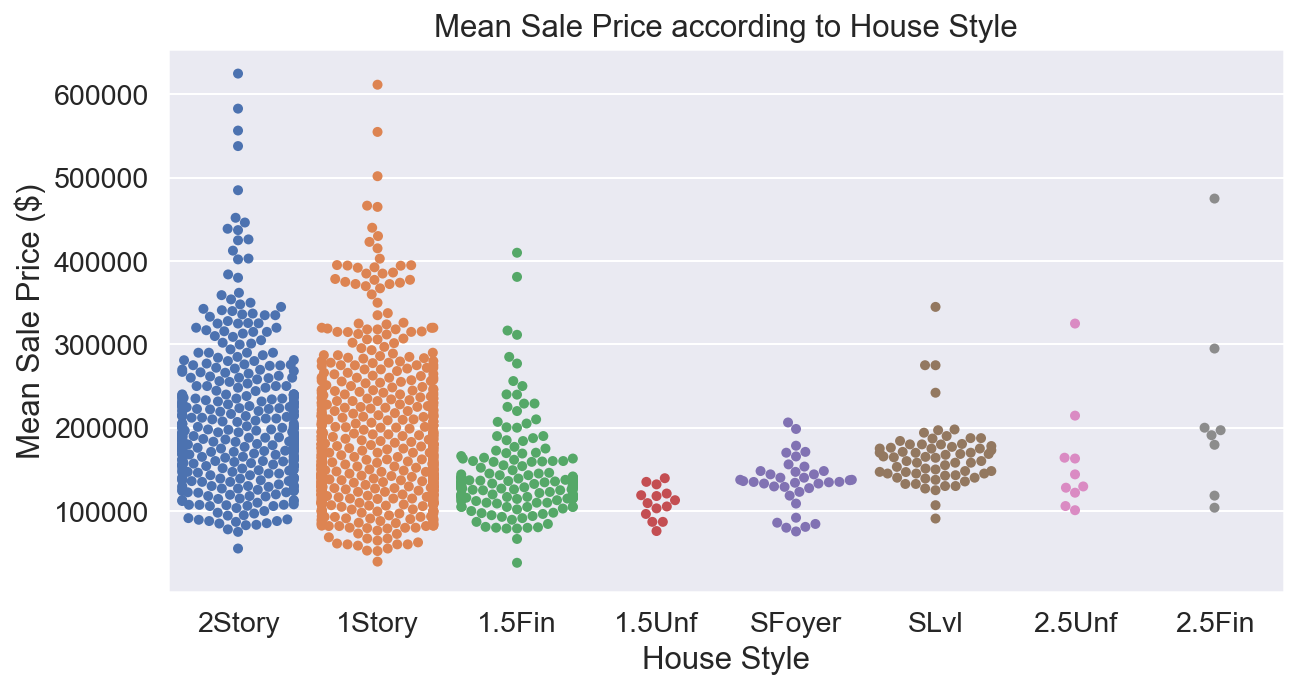

In [14]:
sns.set(rc={'figure.figsize': (10,5)}, font_scale=1.3)
sns.swarmplot(x = 'HouseStyle', y = 'SalePrice', data = res_homes)
plt.ylabel('Mean Sale Price ($)')
plt.xlabel('House Style')
plt.title('Mean Sale Price according to House Style')

### HOME LOT AND LOCATION

### Street:
- Grvl -> Street is made of Gravel
- Pave -> Street is made of Pavement

**Observation :** Only 4 values for Gravl and the mean of Pavement is within the 1 std from the Gravel mean. Do not use for model. 

In [15]:
res_homes.groupby('Street')[['SalePrice']].agg(['mean', 'std','min','max', 'count'])

SalePrice                                    
                 mean           std     min     max count
Street                                                   
Grvl    161037.500000  56818.239076  110000  228950     4
Pave    179365.193619  77024.556394   37900  625000  1379

### LotShape:

- Reg -> Regulator lot shape
- IR1 -> Slightly irregular lot shape
- IR2 -> Moderately irregular lot shape
- IR3 -> irregular lot shape

**Feature Engineering:** Since the values for IR1, IR2, and IR3 overlap, combine into 1 category (IR) 

In [16]:
res_homes.groupby('LotShape')[['SalePrice']].agg(['mean', 'std','min','max', 'count'])

SalePrice                                     
                   mean            std     min     max count
LotShape                                                    
IR1       203498.027601   78693.760293   52000  625000   471
IR2       243851.789474  102168.344089  110000  538000    38
IR3       216036.500000   82540.334855   73000  375000    10
Reg       162863.944444   69322.622853   37900  582933   864

In [17]:
# Combine IR1, IR2, IR3
res_homes.replace(['IR1','IR2', 'IR3'], value='IR', inplace = True)

In [18]:
res_homes.groupby('LotShape')[['SalePrice']].agg(['mean', 'std','min','max', 'count'])

SalePrice                                   
                   mean           std    min     max count
LotShape                                                  
IR        206694.227360  81210.187381  52000  625000   519
Reg       162863.944444  69322.622853  37900  582933   864

### LotArea : Lot size in square feet

### LotFrontage: Linear feet of street connected to property

**Feature Engineering:** Replace LotFrontage of 0 by the mean for that neighborhood. 
**Observation :** LotArea and LotFrontage are only midly correlated to each other and to the price. LotArea is more correlated to the 

In [19]:
res_homes['LotFrontage'] = res_homes.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

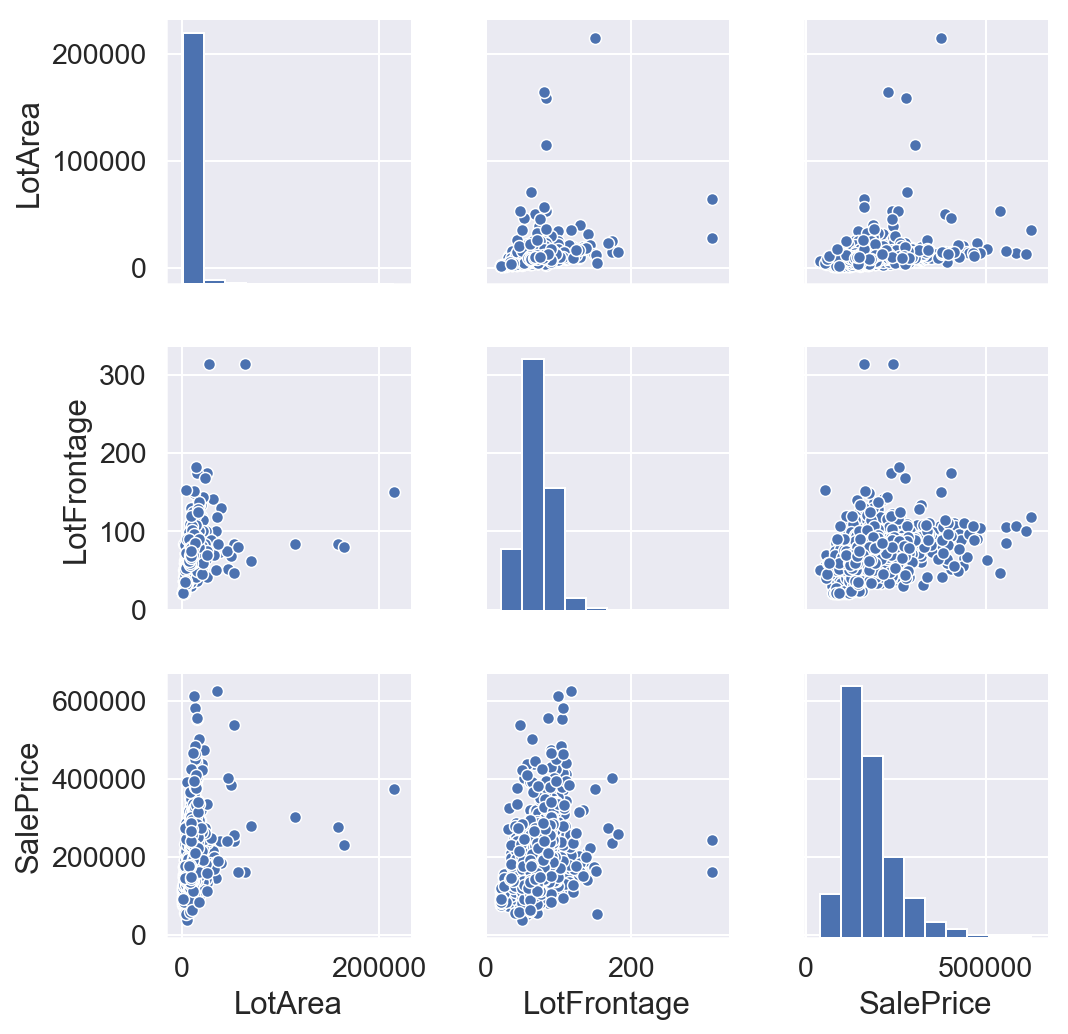

In [20]:
sns.pairplot(res_homes[['LotArea', 'LotFrontage', 'SalePrice']])
#ax.title('Mean Sale Price according to the area of the lot')

### Condition 1 and Condition 2: Proximity to various conditions

- Artery -> Artery
- Feedr -> Banked - Quick and significant rise from street grade to building
- Norm -> Hillside - Significant slope from side to side
- RRNn -> Within 200' of North-South Railroad
- RRAn -> Adjacent to North-South Railroad
- RRAe -> Within 200' of East-West Railroad
- RRNe -> Adjacent to East-West Railroad
- PosN -> Near positive off-site feature--park, greenbelt, etc.
- PosA -> Adjacent to postive off-site feature

**Feature Engineer:** PosA and PosN have similar values. Combine both into Pos.
Note: Condition 1 and Condition 2 have similar values. 

In [21]:
res_homes.groupby('Condition1')[['SalePrice']].agg(['mean', 'std','min','max', 'count'])

SalePrice                                    
                     mean           std     min     max count
Condition1                                                   
Artery      135091.666667  66226.660548   66500  475000    48
Feedr       144500.177215  40517.558949   52500  244600    79
Norm        182712.108769  78718.772988   37900  625000  1186
PosA        225875.000000  52348.932313  180000  335000     8
PosN        215184.210526  65256.536609  109500  385000    19
RRAe        138400.000000  24030.813553   87000  171000    11
RRAn        181235.080000  65507.946510   79500  423000    25
RRNe        190750.000000   5303.300859  187000  194500     2
RRNn        212400.000000  93823.238060  110000  320000     5

In [22]:
res_homes.replace(['RRNn','RRAn', 'RRAe', 'RRNe'], value='RRN', inplace = True)
res_homes.replace(['PosN','PosA'], value='Pos', inplace = True)

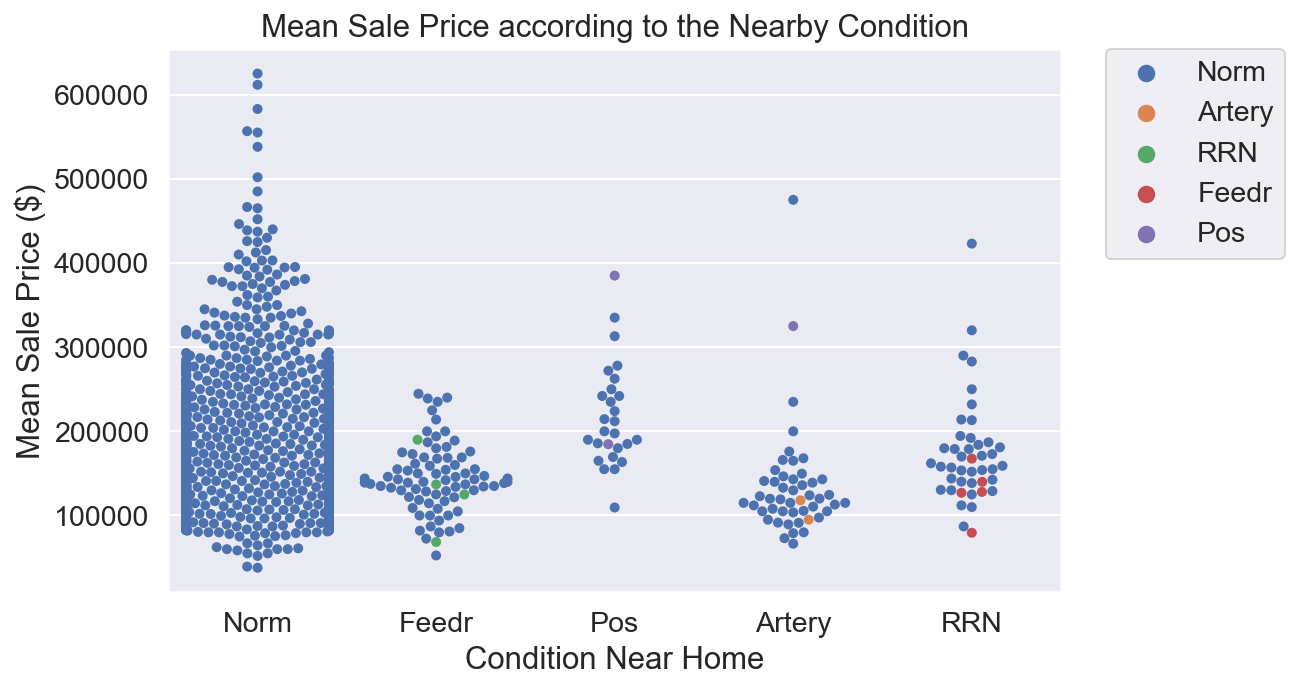

In [23]:
sns.set(rc={'figure.figsize': (8,5)}, font_scale=1.3)
sns.swarmplot(x = 'Condition1', y = 'SalePrice', data = res_homes, hue = 'Condition2')
plt.ylabel('Mean Sale Price ($)')
plt.xlabel('Condition Near Home')
plt.title('Mean Sale Price according to the Nearby Condition')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### LandContour: Flatness of property

- Lvl -> Near Flat/Level
- Bnk -> Banked - Quick and significant rise from street grade to building
- HLS -> Hillside - Significant slope from side to side
- Low -> Depression

### LandSlope:

- Gtl -> Gentle slope
- Mod -> Moderate Slope
- Sev -> Severe Slope

**Observation :** There is a high correlation between LandSlope and Land Contour since both demonstrate the shape of the land. Houses who are located near a hill seem to sell for more. 

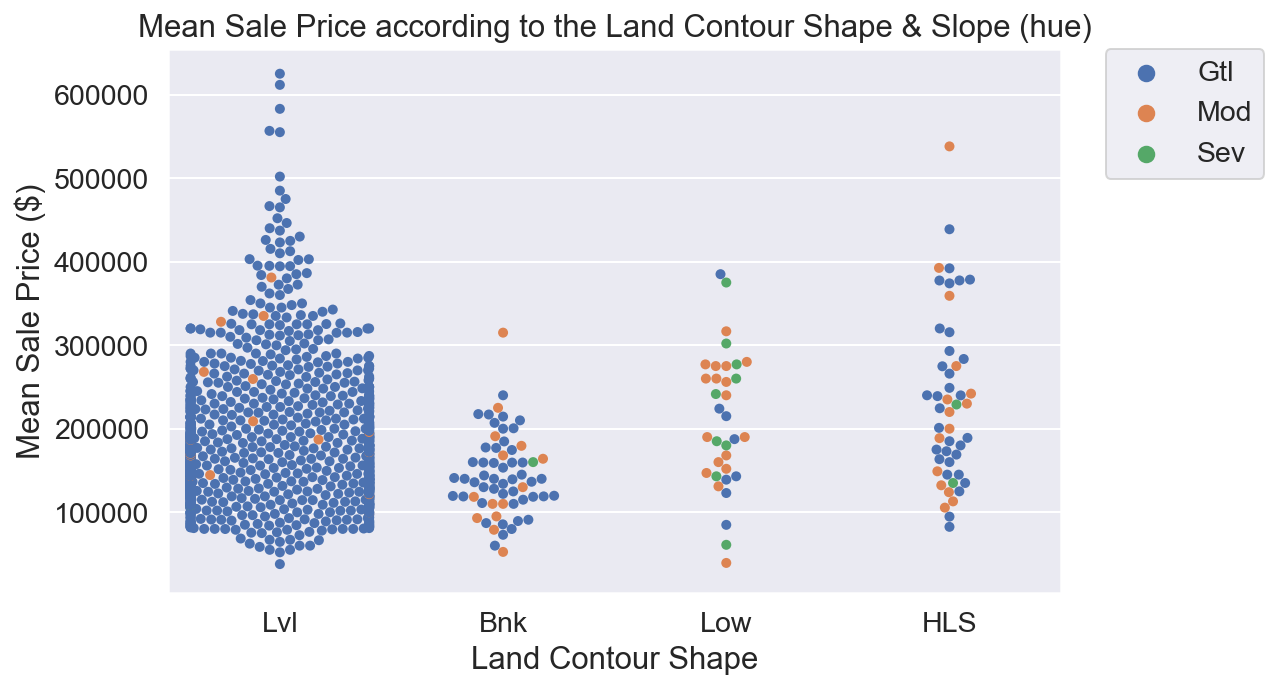

In [24]:
sns.set(rc={'figure.figsize': (8,5)}, font_scale=1.3)
sns.swarmplot(x = 'LandContour', y = 'SalePrice', data = res_homes, hue = 'LandSlope')
plt.ylabel('Mean Sale Price ($)')
plt.xlabel('Land Contour Shape')
plt.title('Mean Sale Price according to the Land Contour Shape & Slope (hue)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Build dates information : 

- YrSold : Year of Sale
- YearBuilt : Year Built
- Home Age = YearBuilt - YrSold (Important)

**Feature Engineering:** Home_Age = YearBuilt - YrSold

**Observation :** The Sale Price decreases with the age of the home

**Verdict :** Keep for model

In [25]:
# Calculate Age of home at sale date
res_homes['home_age'] = res_homes['YrSold'] - res_homes['YearBuilt']

Text(0.5, 1.0, 'Mean Sale Price according to the age of the home')

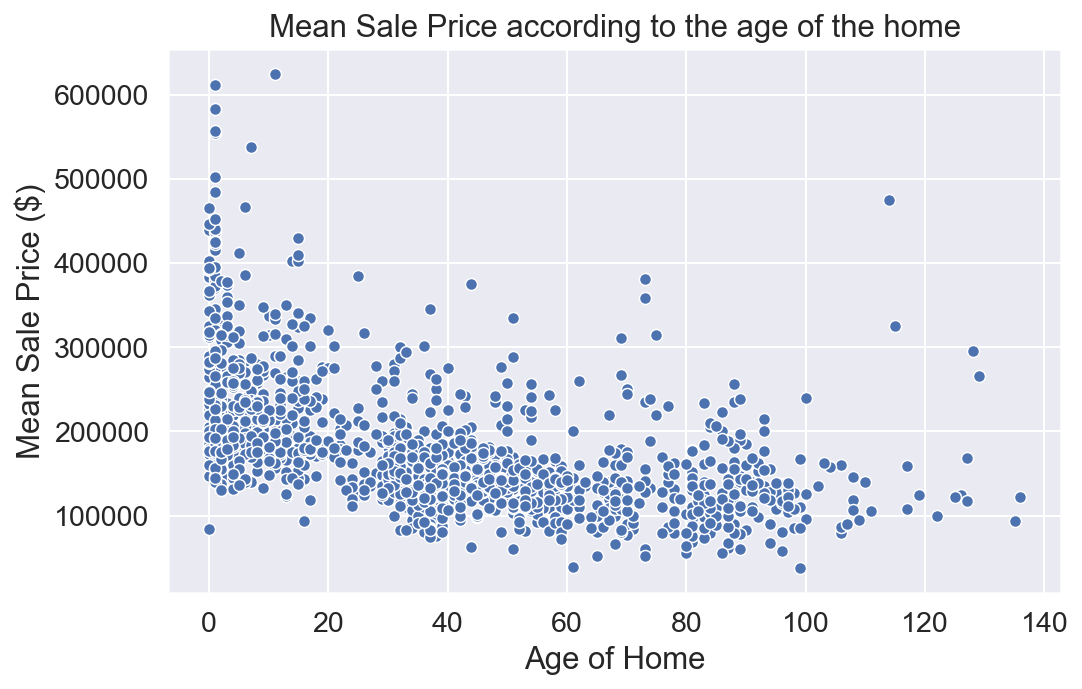

In [26]:
sns.set(rc={'figure.figsize': (8,5)}, font_scale=1.3)
sns.scatterplot(x = 'home_age', y = 'SalePrice', data = res_homes)
plt.ylabel('Mean Sale Price ($)')
plt.xlabel('Age of Home')
plt.title('Mean Sale Price according to the age of the home')

### Home Size and Space information : 

- BsmtFinSF1 -> Finished Basement Area with quality 1  (sqft)
- BsmtFinSF2 -> FInished Basement Area with quality 2 (sqft)
- BsmtUnfSF -> Unfinished Basement Area  (sqft)
- TotBsmtSF -> Total area of basement (sqft)
- 1stFlrSF -> Total area of 1st Floor (sqft)
- 2ndFlrSF -> Total area of 2nd Floor (sqft)
- GarageArea -> Total garage of 2nd Floor (sqft)
- GrLivArea -> Total Living Area above ground  (sqft)
- TotRmsAbvGrd ->  Total Number of Rooms above ground
- KitchenAbvGr -> Total Number of Kitchens above ground
- BedroomAbvGr -> Total Number of Bedrooms above ground
- FullBath -> Total Number of Baths
- HalfBath -> Total Number of Baths


**Feature Engineering:** Home Size = TotBsmtSF + 1stFlrSF + 2ndFlrSF

**Observation :** By summing the total home size with the feature engineering, home Sale is now correlated at 0.8 to the home_price. The other features are highly correlated with the home size or are not correlated with SalePrice. 

In [27]:
res_homes['home_size'] = res_homes[['TotalBsmtSF','1stFlrSF', '2ndFlrSF']].sum(axis = 1)

Text(0.5, 1.0, 'Mean Sale Price according to the Total Size of the Home')

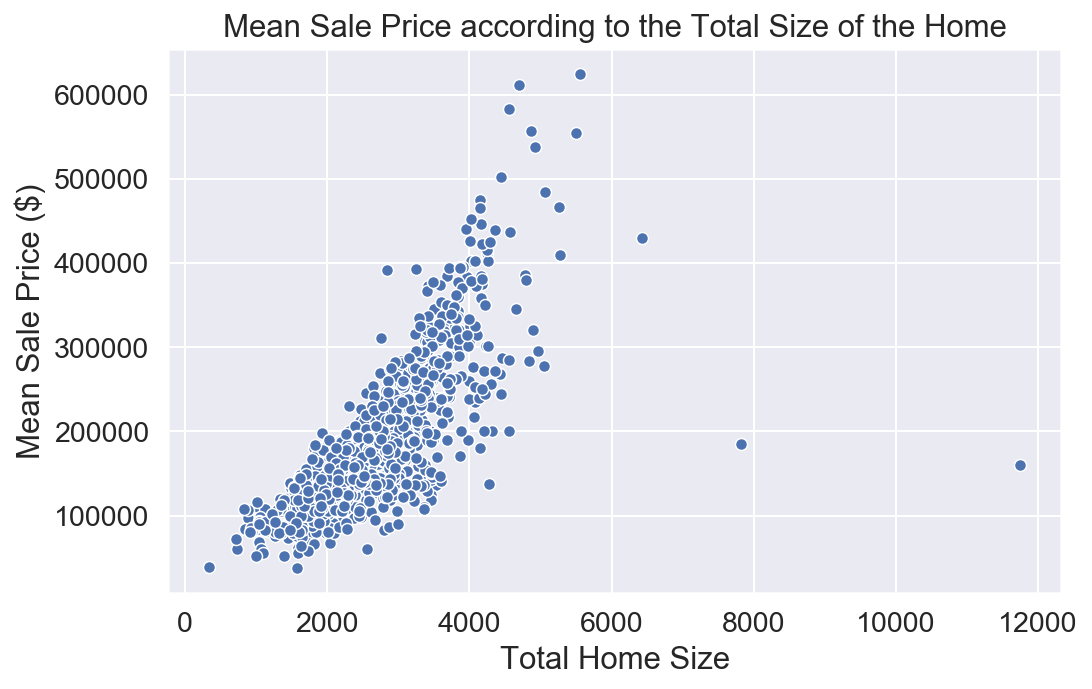

In [28]:
sns.set(rc={'figure.figsize': (8,5)}, font_scale=1.3)
sns.scatterplot(x = 'home_size', y = 'SalePrice', data = res_homes)
plt.ylabel('Mean Sale Price ($)')
plt.xlabel('Total Home Size')
plt.title('Mean Sale Price according to the Total Size of the Home')

In [29]:
# Remove outliers 
res_homes = res_homes[res_homes['home_size'] < 7000]

# Pre-selected Features According to EDA:

- Neighborhood
- MSSubClass
- MSZoning
- BldgType
- HouseStyle
- LotShape
- LandContour
- Condition1
- Condition2
- home_age
- home_size
- GrLivArea
- TotRmsAbvGrd
- BedroomAbvGr
- FullBath
- HalfBath

# Linear Regression Price Prediction Model
**Preparing Data for Modeling**

**By using the classifier, these are the top fixed important features that were kept for the model** 

In [30]:
# Target and Year of Sale for train, test, hold selection
hold = res_homes[['SalePrice', 'YrSold']]
hold.reset_index(drop = True, inplace = True)

#split into categorical versus numerical
for_dummies = res_homes[['Neighborhood', 'MSSubClass','MSZoning','BldgType','HouseStyle', 'LotShape']]
for_std = res_homes[['home_age','home_size', 'HalfBath']]

#standardizing using RobustScaler
scaler = RobustScaler()
scaler.fit(for_std)
std = scaler.transform(for_std)

# Encoding for the Decision Tree Classifier
X_dum = for_dummies.apply(LabelEncoder().fit_transform)
X_dum.reset_index(drop = True, inplace = True)

# Make a new dataframe of the encoded and the Scaled values
X_num = pd.DataFrame(std, columns = for_std.columns)
X_num.reset_index(drop = True, inplace = True)
data = pd.concat([hold, X_num, X_dum], axis = 1)

# Training data is only using the pre 2010 housing data
train = data[data['YrSold'] < 2010]

# Separate into target and predictors
X = train.drop(columns = ['SalePrice', 'YrSold'])
y = train['SalePrice'].values

In [31]:
classifier = DecisionTreeClassifier(criterion='gini',max_depth=None)
regressor = DecisionTreeRegressor(criterion='mse',max_depth=20)
regressor.fit(X, y)
Y_pred = regressor.predict(X)
feature_importances = regressor.feature_importances_

(0, 0.02)

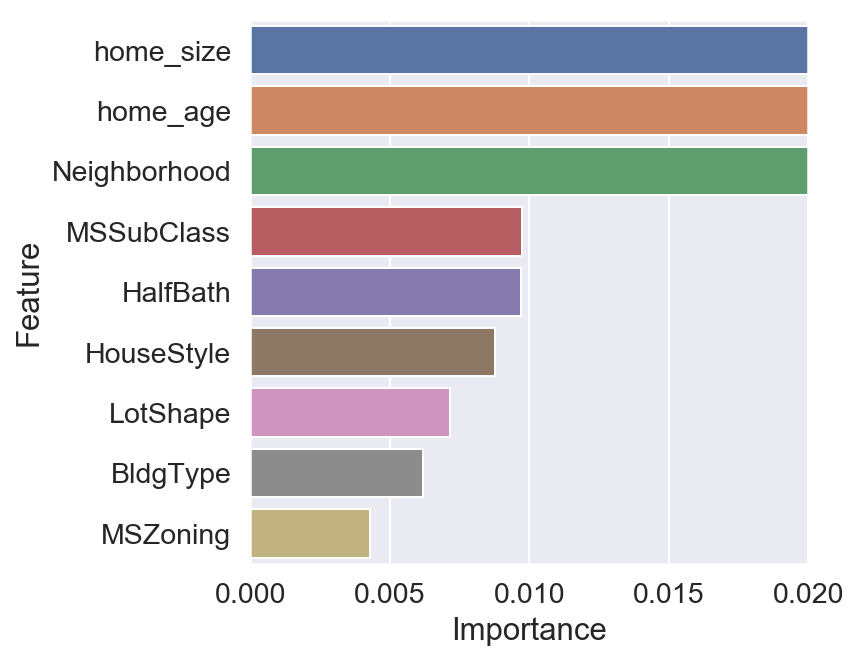

In [32]:

feature_selection = pd.DataFrame(X.columns, columns = ['Feature'])
feature_selection['Importance'] = feature_importances
feature_selection.sort_values(by = 'Importance', ascending = False, inplace = True)
fs = feature_selection.head(20)

sns.set(rc={'figure.figsize': (5,5)}, font_scale=1.3)
sns.barplot(x = 'Importance', y = 'Feature', data = fs)
plt.xlim(0,0.02)

In [33]:
feature_selection.reset_index(drop = True).head(10)

Feature  Importance
0     home_size    0.775242
1      home_age    0.136391
2  Neighborhood    0.042499
3    MSSubClass    0.009744
4      HalfBath    0.009714
5    HouseStyle    0.008754
6      LotShape    0.007173
7      BldgType    0.006177
8      MSZoning    0.004305

In [34]:
#standardizing using RobustScaler
scaler = RobustScaler()
scaler.fit(for_std)
std = scaler.transform(for_std)

# New DataFrame of dummies and scaled features
X_num = pd.DataFrame(std, columns = for_std.columns)

X_dum = pd.get_dummies(for_dummies, drop_first=True)
X_num.reset_index(drop = True, inplace = True)
X_dum.reset_index(drop = True, inplace = True)

data = pd.concat([hold, X_num, X_dum], axis = 1)

# Training data is only using the pre 2010 housing data
train = data[data['YrSold'] < 2010]

# Separate into target and predictors
X = train.drop(columns = ['SalePrice', 'YrSold'])
y = train['SalePrice'].values


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.20)

In [36]:
alphas = np.logspace(-0.001, 10, 500)

kf = KFold(10, random_state=42).get_n_splits(X_train)
ridge = RidgeCV(alphas=alphas, cv = kf, scoring = 'r2')
ridge = ridge.fit(X_train, y_train)

print('Training Specs ---------')
print(ridge)
print('Best Alpha:', ridge.alpha_)
print('Intercept:',  ridge.intercept_)
y_predict = ridge.predict(X_test)
print('R2:',r2_score(y_test, y_predict))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_predict)))

Training Specs ---------
RidgeCV(alphas=array([9.97700e-01, 1.04482e+00, ..., 9.54900e+09, 1.00000e+10]),
    cv=10, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='r2', store_cv_values=False)
Best Alpha: 3.020021397516559
Intercept: 178173.89830498394
R2: 0.7173041402529906
RMSE: 32694.022819542777


In [37]:
# Extracting R2 cross validation scores from our model
kf = KFold(10, random_state=42).get_n_splits(X_train)
scores = cross_val_score(ridge, X_train, y_train, scoring="r2", cv = kf)
print('R2 scores for 10 cv', scores)
print('Mean R2 Scores:', np.mean(scores))
print('Std R2 Scores:', np.std(scores))

R2 scores for 10 cv [0.85231396 0.68469491 0.80246658 0.75151657 0.86556609 0.85652163
 0.8271328  0.82474592 0.81473766 0.8777796 ]
Mean R2 Scores: 0.8157475717046733
Std R2 Scores: 0.05569371822940557


**The model is stable over several cross validations with kfold, but in still has approx. 20% error (mean R2 = 0.8)**

**Predicting House Prices of 2010 using the model from above**

In [38]:
hold = data[data['YrSold'] >= 2010]
X_2010 = hold.drop(columns = ['SalePrice', 'YrSold'])
y_2010 = hold['SalePrice'].values 

y_predicted_2010 = ridge.predict(X_2010)
print('R2:', r2_score(y_2010, y_predicted_2010))
print('RMSE:',np.sqrt(mean_squared_error(y_2010, y_predicted_2010)))

R2: 0.8279491502505871
RMSE: 33576.47452091452


Text(0.5, 0, 'Predicted Prices')

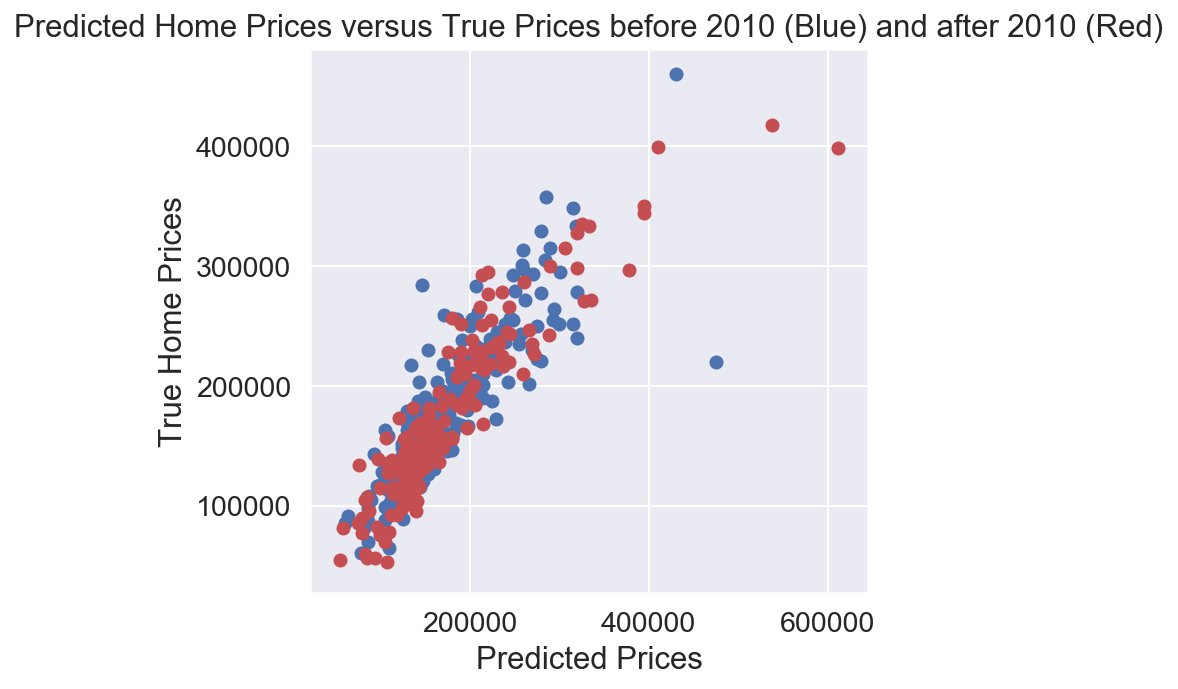

In [39]:
plt.scatter(y_test, y_predict)
plt.scatter(y_2010, y_predicted_2010, color = 'r')
plt.title('Predicted Home Prices versus True Prices before 2010 (Blue) and after 2010 (Red)')
plt.ylabel('True Home Prices')
plt.xlabel('Predicted Prices')

**Obtaining Dollar Values for each feature using the model coefficients**

In [40]:
conversion_of_coef_list =[tuple(ridge.coef_)]
coefs = pd.DataFrame(conversion_of_coef_list, columns = X.columns, index = ['Dollar Value ($)'])

# Reversing the Standardardization of the Home age and the Home Size
coefs[['home_age','home_size','HalfBath']] = scaler.transform(coefs[['home_age','home_size','HalfBath']])

In [51]:
coefs = coefs.round(2)
print('------------------------------------------------')
print('Home Age, Size, HalfBath')
print(coefs.iloc[:,0:4])
print('------------------------------------------------')
print('Neighborhood')
print(coefs.iloc[:,4:15])
print(coefs.iloc[:,15:28])
print('------------------------------------------------')
print('House Zoning')
print(coefs.iloc[:,28:30])
print('------------------------------------------------')
print('Building Type')
print(coefs.iloc[:,30:34])
print('------------------------------------------------')
print('House Style')
print(coefs.iloc[:,34:41])
print('------------------------------------------------')
print('Lot Shape')
print(coefs.iloc[:,41:42])

------------------------------------------------
Home Age, Size, HalfBath
                  home_age  home_size  HalfBath  MSSubClass
Dollar Value ($)   -634.59       56.0   6551.24      -150.3
------------------------------------------------
Neighborhood
                  Neighborhood_Blueste  Neighborhood_BrDale  \
Dollar Value ($)               -766.29             -4581.99   

                  Neighborhood_BrkSide  Neighborhood_ClearCr  \
Dollar Value ($)               1885.44                 60.91   

                  Neighborhood_CollgCr  Neighborhood_Crawfor  \
Dollar Value ($)             -12692.61              22457.36   

                  Neighborhood_Edwards  Neighborhood_Gilbert  \
Dollar Value ($)             -16233.53              -18308.5   

                  Neighborhood_IDOTRR  Neighborhood_MeadowV  \
Dollar Value ($)             -6443.54             -13740.14   

                  Neighborhood_Mitchel  
Dollar Value ($)              -19547.1  
                  Nei

## Limitations of the Model

**Testing Method:**
- Choose a random home from 2010 with a: 
    - 1) Median SalePrice
    - 2) Mean SalePrice
    - 3) a SalePrice above $500,000
- Compare the Predicted Price to the Real Sale Price
- Measure the Percent Difference between the Sale Prices

In [52]:
print('Median Sale Price',round(data['SalePrice'].median(),0))
print('Average Sale Price',round(data['SalePrice'].mean(),0))

Median Sale Price 160000.0
Average Sale Price 179322.0


In [53]:
# Predicting Median value homes

median_homes = data[(data['YrSold'] == 2010) & (data['SalePrice'].between(15900.0, 161000.0))]
sample = median_homes.sample(n=1)
X_sample = sample.drop(columns = ['SalePrice', 'YrSold'])
median_predict = ridge.predict(X_sample.values)

print('-----------------------------------------------------')
print('**Median versus Predicted**')
print('Predicted Sale Price: ', round(median_predict[0],2))
print('Real Sale Price: ', round(sample['SalePrice'].sum(),2))
print('Percent Difference: ', round((((sample['SalePrice'].sum() - median_predict[0])/sample['SalePrice'].sum())*100) ,2), '%')

# Predicting Outlier value homes
mean_homes = data[(data['YrSold'] == 2010) & (data['SalePrice'].between(17800.0, 179000.0))]
sample_m = mean_homes.sample(n=1)
X_sample_m = sample_m.drop(columns = ['SalePrice', 'YrSold'])
mean_predict = ridge.predict(X_sample_m.values)

print('-----------------------------------------------------')
print('**Mean versus Predicted**')
print('Predicted Sale Price: ', round(mean_predict[0],2))
print('Real Sale Price: ', round(sample_m['SalePrice'].sum(),2))
print('Percent Difference: ', round((((sample_m['SalePrice'].sum() - mean_predict[0])/sample_m['SalePrice'].sum())*100) ,2), '%')

# Prediction Outlier value homes (above $500,000)
outlier_homes = data[(data['YrSold'] == 2010) & (data['SalePrice'] >500000)]
sample_o = outlier_homes.sample(n=1)
X_sample_o = sample_o.drop(columns = ['SalePrice', 'YrSold'])
outlier_predict = ridge.predict(X_sample_o.values)

print('-----------------------------------------------------')
print('**Outlier versus Predicted**')
print('Predicted Sale Price: ', round(outlier_predict[0],2))
print('Real Sale Price: ', round(sample_o['SalePrice'].sum(),2))
print('Percent Difference: ', round((((sample_o['SalePrice'].sum() - outlier_predict[0])/sample_o['SalePrice'].sum())*100) ,2), '%')

-----------------------------------------------------
**Median versus Predicted**
Predicted Sale Price:  135629.83
Real Sale Price:  133000
Percent Difference:  -1.98 %
-----------------------------------------------------
**Mean versus Predicted**
Predicted Sale Price:  92742.13
Real Sale Price:  112000
Percent Difference:  17.19 %
-----------------------------------------------------
**Outlier versus Predicted**
Predicted Sale Price:  398522.56
Real Sale Price:  611657
Percent Difference:  34.85 %


## Conclusion 
________________________________________________________

The Model gives predictions on Sale price within 20% of the real sale price. It is more efficient on homes that sold for median and mean prices compared to outlier (Q3+1.5IQR) home sale prices. 

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

## Visualization of Renovatable Features
-----
**Note: Due to the sheer amount of renovatable features, I will be using a classifier to rank the renovatable features**

**This Section will focus on data cleaning / engineering**

In [54]:
missing_values[missing_values['%  Missing Data'].between(0,100, inclusive = False)].sort_values(by ='%  Missing Data', ascending = False)

%  Missing Data
PoolQC              99.494585
MiscFeature         96.245487
Alley               95.306859
Fence               80.000000
FireplaceQu         46.281588
LotFrontage         18.122744
GarageType           5.703971
GarageYrBlt          5.703971
GarageFinish         5.703971
GarageQual           5.703971
GarageCond           5.703971
BsmtExposure         2.743682
BsmtFinType2         2.743682
BsmtFinType1         2.671480
BsmtCond             2.671480
BsmtQual             2.671480
MasVnrArea           0.361011
MasVnrType           0.361011
Electrical           0.072202

### Quality Features 

#### Features with the following Scale :
- OverallQual: Overall Quality of the home
- OverallCond: Overall Condition of the home

- 10 -> Very Excellent
- 9 -> Excellent
- 8 -> Very Good
- 7 -> Good
- 6 -> Above Average
- 5 -> Average
- 4 -> Below Average
- 3 -> Fair
- 2 -> Poor
- 1 -> Very Poor

#### Features with the Following Scale : 
- ExterQual: Quality of the Exterior
- ExterCond: Condition of the Exterior
- BsmtCond : Condition of Basement
- KitchenQual : Quality of the Kitchen
- GarageQual: Quality of the Garage
- GarageCond: Condition of the Garage
- PoolQC: Quality of the Pool
- FireplaceQu : Quality of the Fireplace
- HeatingQC

Change the Scale to this:
- Ex -> Excellent 
- Gd -> Good 
- TA -> Average/ Typical
- FA -> Fair
- Po -> Poor
- None -> None

#### BsmtFinType1 : Rating of basement finished area
- GLQ -> Good Living Quarters
- ALQ -> Average Living Quarters
- BLQ -> Below Average Living Quarters
- Rec -> Average Rec Room
- LwQ -> Low Quality
- Unf -> Unfinshed
- NA -> No Basement -> None
      
#### BsmtExposure
- Gd-> Good Exposure
- Av-> Average Exposure
- Mn-> Mimimum Exposure
- No-> No Exposure
- NA-> No Basement -> None
       
#### Functional
- Typ -> Typical Functionality
- Min1 -> Minor Deductions 1
- Min2 -> Minor Deductions 2
- Mod -> Moderate Deductions
- Maj1 -> Major Deductions 1
- Maj2 -> Major Deductions 2
- Sev -> Severely Damaged
- Sal -> Salvage only

In [55]:
# Fill np.nan with None
res_homes[['BsmtCond', 'BsmtQual', 'FireplaceQu','KitchenQual', 'GarageQual', 'GarageCond','PoolQC',
           'BsmtFinType1','BsmtFinType2','BsmtExposure']] = res_homes[['BsmtCond', 'BsmtQual','FireplaceQu','KitchenQual', 'GarageQual', 'GarageCond','PoolQC',
                                                           'BsmtFinType1','BsmtFinType2','BsmtExposure']].replace(np.nan,'None')

### Utilities

#### CentralAir: Central air conditioning
- Y -> Yes
- N -> No

#### Electrical: Type of Electrical Circuit
- SBrkr -> Standard Circuit Breakers & Romex
- FuseA -> Fuse Box over 60 AMP and all Romex wiring (Average)	
- FuseF -> 60 AMP Fuse Box and mostly Romex wiring (Fair)
- FuseP -> 60 AMP Fuse Box and mostly knob & tube wiring (poor)
- Mix -> Mixed


#### Utilities: Type of Utilities
- AllPub -> All public Utilities (E,G,W,& S)
- NoSewr -> Electricity, Gas, and Water (Septic Tank)
- NoSeWa -> Electricity and Gas Only
- ELO -> Electricity only

#### Heating: Type of heating
- Floor -> Floor Furnace
- GasA -> Gas forced warm air furnace
- GasW -> Gas hot water or steam heat
- Grav -> Gravity furnace
- OthW -> Hot water or steam heat other than gas
- Wall -> Wall furnace

**Observation :**  
- Do Not use Utilties since all, but 1 have AllPub Services.


In [56]:
# Change CentralAir to binary
res_homes = res_homes.replace({'CentralAir':{ 'Y' : 1, 'N' : 0}})

# replace missing value by the most common value
res_homes['Electrical'] = res_homes['Electrical'].replace(np.nan, 'SBrkr')

# group floor with gravity
res_homes['Heating'] = res_homes['Heating'].replace('Floor', 'Grav')

In [57]:
print(res_homes.groupby('CentralAir')['SalePrice'].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes.groupby('Electrical')['SalePrice'].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes.groupby('Utilities')['SalePrice'].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes.groupby('Heating')['SalePrice'].agg(['mean', 'std', 'count']))
print('---------------------------------------------')

                     mean           std  count
CentralAir                                    
0           108033.516854  39463.087107     89
1           184232.986842  76551.790591   1292
---------------------------------------------
                     mean           std  count
Electrical                                    
FuseA       125465.600000  34746.602253     90
FuseF       107675.444444  30636.507376     27
FuseP        97333.333333  34645.827070      3
Mix          67000.000000           NaN      1
SBrkr       184988.778571  77586.981569   1260
---------------------------------------------
                    mean           std  count
Utilities                                    
AllPub     179352.537681  77038.389347   1380
NoSeWa     137500.000000           NaN      1
---------------------------------------------
                  mean           std  count
Heating                                    
GasA     180414.239259  76769.861137   1350
GasW     168557.588235  80525

### Home Exterior
#### RoofStyle: Style of the Roof
- Flat, Gable, Gambrel, Hip, Mansard, Shed

#### RoofMatl: Roof Material
- ClyTile -> Clay or Tile
- CompShg -> Standard (Composite) Shingle
- Membran -> Membrane
- Metal -> Metal
- Roll -> Roll
- Tar&Grv -> Gravel & Tar
- WdShake -> Wood Shakes
- WdShngl -> Wood Shingles

#### Exterior1st & Exterior2nd: Type of Material for the 1st and 2nd floor
- AsbShng -> Asbestos Shingles
- AsphShn -> Asphalt Shingles
- BrkComm -> Brick Common
- BrkFace -> Brick Face
- CBlock -> Cinder Block
- CemntBd -> Cement Board
- HdBoard -> Hard Board
- ImStucc -> Imitation Stucco
- MetalSd -> Metal Siding
- Other -> Other
- Plywood -> Plywood
- PreCast -> PreCast
- Stone -> Stone
- Stucco -> Stucco
- VinylSd -> Vinyl Siding
- Wd Sdng -> Wood Siding
- WdShing -> Wood Shingles

**Note**
- RoofMatl : Most are made of Composite Standard Shingle. There are few in other categories. Do not Use for model

In [58]:
# Combine those with single values into other category
res_homes[['Exterior1st', 'Exterior2nd', 'RoofStyle']] = res_homes[['Exterior1st', 'Exterior2nd', 'RoofStyle']].replace(['Gambrel', 'Mansard', 'Flat', 'Shed','AsphShn', 'CBlock'], 'Other')
                               
# Combine types of wood
res_homes[['Exterior1st', 'Exterior2nd']] = res_homes[['Exterior1st', 'Exterior2nd']].replace(['Wd Sdng', 'WdShing', 'Wd Shng', 'HdBoard', 'Plywood'], 'Wood')

In [59]:
print(res_homes.groupby('RoofStyle')['SalePrice'].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes.groupby('RoofMatl')['SalePrice'].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes.groupby('Exterior1st')['SalePrice'].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes.groupby('Exterior2nd')['SalePrice'].agg(['mean', 'std', 'count']))
print('---------------------------------------------')

                    mean            std  count
RoofStyle                                     
Gable      169053.861137   63497.785775   1073
Hip        218863.260870  107982.411231    276
Other      182592.156250   60152.331511     32
---------------------------------------------
                   mean            std  count
RoofMatl                                     
CompShg   178520.657332   76626.962898   1357
Membran   241500.000000            NaN      1
Metal     180000.000000            NaN      1
Roll      137000.000000            NaN      1
Tar&Grv   185406.363636   65430.141720     11
WdShake   241400.000000   36218.779659      5
WdShngl   317300.000000  116758.083232      5
---------------------------------------------
                      mean            std  count
Exterior1st                                     
AsbShng      111178.947368   29983.654416     19
BrkComm       71000.000000   15556.349186      2
BrkFace      197727.551020   80609.130907     49
CemntBd      2


#### MasVnrArea:
- Area of House Veneer in Square Feet

#### MasVnrType: 
- BrkCmn -> Brick Common
- BrkFace -> Brick Face
- CBlock -> Cinder Block
- None -> None
- Stone -> Stone

#### Foundation: Type of foundation
- BrkTil -> Brick & Tile
- CBlock -> Cinder Block
- PConc -> Poured Contrete
- Slab -> Slab
- Stone -> Stone
- Wood -> Wood

#### Alley: Whether there is an alley and the type of alley
- Gvl -> Gravel
- Pave -> Paved
- NA -> No Access

#### PavedDrive
- Y -> Paved
- P -> Partial Pavement
- N -> Dirt /Gravel

#### Fence: Quality of the Fence
- GdPrv -> Good Privacy  
- MnPrv -> Minimum Privacy 
- GdWo -> Good Wood -> 
- MnWw -> Minimum Wood/Wire
- NA -> No Fence 

In [60]:
# Fill missing values with None. 
res_homes[['MasVnrType','Alley','PavedDrive','Fence']] = res_homes[['MasVnrType','Alley','PavedDrive','Fence']].replace(np.nan,'None')
res_homes['MasVnrArea'] =res_homes['MasVnrArea'].replace(np.nan,0)

In [61]:
print(res_homes['MasVnrArea'].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes.groupby('MasVnrType')['SalePrice'].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes.groupby('Foundation')['SalePrice'].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes.groupby('Alley')['SalePrice'].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes.groupby('PavedDrive')['SalePrice'].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes.groupby('Fence')['SalePrice'].agg(['mean', 'std', 'count']))
print('---------------------------------------------')

mean      100.719044
std       170.064380
count    1381.000000
Name: MasVnrArea, dtype: float64
---------------------------------------------
                     mean            std  count
MasVnrType                                     
BrkCmn      146318.066667   46187.583632     15
BrkFace     203651.236659   77711.923400    431
None        154619.324390   57084.778770    820
Stone       268588.713043  102693.044385    115
---------------------------------------------
                     mean           std  count
Foundation                                    
BrkTil      132920.812500  54424.543422    144
CBlock      150730.811802  47685.367359    627
PConc       224858.878893  84644.516902    578
Slab        107365.625000  34213.980939     24
Stone       178595.800000  80724.887044      5
Wood        185666.666667  56695.090910      3
---------------------------------------------
                mean           std  count
Alley                                    
Grvl   122219.0800

### Home Added Extra Features
**WoodDeckSF : area of Deck in square feet**

**OpenPorchSF : area of an opened porch in square feet**

**EnclosedPorch : area of an enclosed porch in square feet**

**3SsnPorch : area of a 3 seasons porch in square feet**

**ScreenPorch : area of a screen porch in square feet**

**PoolArea : area of pool**

**GarageType: type of garage**
- 2Types -> More than one type of garage
- Attchd -> Attached to home
- Basment -> Basement Garage
- BuiltIn -> Built-In (Garage part of house - typically has room above garage)
- CarPort -> Car Port
- Detchd -> Detached from home
- NA -> No Garage


**GarageYrBlt: Year garage was built**
**GarageCars: Number of cars that can fit in the garage**
**GarageFinish:**
- Fin -> Finished
- RFn -> Rough Finished
- Unf -> Unfinished
- NA -> None

**Fireplaces: Number of Fireplaces**
**MiscFeature: Type of miscellanerous feature**
**MiscVal: Value of miscellaneous feature**


**Verdict:** 
- Keep all the categorical data
- Numerical High Correlation with SalePrice Values: WoodDeckSF ,OpenPorchSF GarageCars, Fireplaces


In [62]:
# Change np.nan to None for Garage features
res_homes[['GarageYrBlt','GarageType', 'GarageFinish','MiscFeature']] = res_homes[['GarageYrBlt','GarageType', 'GarageFinish','MiscFeature']].replace(np.nan,'None')

In [63]:
print(res_homes[['WoodDeckSF']].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes[['OpenPorchSF']].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes[['EnclosedPorch']].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes[['WoodDeckSF']].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes[['3SsnPorch']].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes[['ScreenPorch']].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes[['PoolArea']].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes[['GarageCars']].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes[['MiscVal']].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes.groupby('GarageType')['SalePrice'].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes.groupby('GarageFinish')['SalePrice'].agg(['mean', 'std', 'count']))
print('---------------------------------------------')
print(res_homes.groupby('MiscFeature')['SalePrice'].agg(['mean', 'std', 'count']))

        WoodDeckSF
mean     96.162925
std     126.854602
count  1381.000000
---------------------------------------------
       OpenPorchSF
mean     43.394642
std      62.562652
count  1381.000000
---------------------------------------------
       EnclosedPorch
mean       22.612600
std        62.145643
count    1381.000000
---------------------------------------------
        WoodDeckSF
mean     96.162925
std     126.854602
count  1381.000000
---------------------------------------------
         3SsnPorch
mean      3.604634
std      30.133136
count  1381.000000
---------------------------------------------
       ScreenPorch
mean     15.707458
std      56.959901
count  1381.000000
---------------------------------------------
          PoolArea
mean      2.167270
std      36.329235
count  1381.000000
---------------------------------------------
        GarageCars
mean      1.750905
std       0.753884
count  1381.000000
---------------------------------------------
           MiscV

**Anymore Missing Values ? No More = Good to Go !**

In [113]:
a = (res_homes.isnull().sum()/len(res_homes))*100
missing_values = pd.DataFrame({'%  Missing Data' : a})
missing_values[missing_values['%  Missing Data'].between(0,100, inclusive = False)].sort_values(by = '%  Missing Data', ascending = False)

Empty DataFrame
Columns: [%  Missing Data]
Index: []

# Pre-selecting Renovatable Features after feature engineering. 
Note these features had no importance during feature selection : '3SsnProch', 'PoolArea', 'PoolQC','CentralAir','HeatingQC','MiscVal','MiscFeature', 'PavedDrive', 'Electrical', 
'OverallCond was removed since it is almost identical to OverallQual


In [65]:
#reset index
res_homes.reset_index(drop = True, inplace = True)

In [66]:
holdr = res_homes[['SalePrice', 'YrSold']]

#Overall Quality is the only quality feature that is kept as a numerical value. 
# Other features are not continuous and contain None values. 
for_stdr = res_homes[['OverallQual','MasVnrArea','WoodDeckSF','OpenPorchSF','EnclosedPorch']]

for_dummiesr = res_homes[['Fence','Alley',
                          'GarageType','GarageFinish','GarageQual', 'GarageCond','Foundation',
                          'BsmtFinType1','BsmtFinType2','BsmtExposure', 'BsmtCond', 'BsmtQual',
                          'Exterior1st','Exterior2nd', 'ExterQual','RoofStyle', 'ExterCond',
                          'FireplaceQu','KitchenQual']]

#standardizing using RobustScaler
scaler = RobustScaler()
scaler.fit(for_stdr)
stdr = scaler.transform(for_stdr)

#Label Encoding for Decision Tree 
le = preprocessing.LabelEncoder()
X_dumr = for_dummiesr.apply(LabelEncoder().fit_transform)

X_dumr.reset_index(drop = True, inplace = True)
holdr.reset_index(drop = True, inplace = True)

#Return the transformed values to a DataFrame
X_numr = pd.DataFrame(stdr, columns = for_stdr.columns)
datar = pd.concat([holdr, X_numr, X_dumr], axis = 1)

# Training data is only using the pre 2010 housing data
trainr = datar[datar['YrSold'] < 2010]

# Separate into target and predictors
Xr = trainr.drop(columns = ['SalePrice', 'YrSold'])
yr = trainr['SalePrice'].values

In [67]:
classifier = DecisionTreeClassifier(criterion='gini',max_depth=None)
regressorr = DecisionTreeRegressor(criterion='mse',max_depth=10)
regressorr.fit(Xr, yr)
feature_importancesr = regressorr.feature_importances_

(0, 0.02)

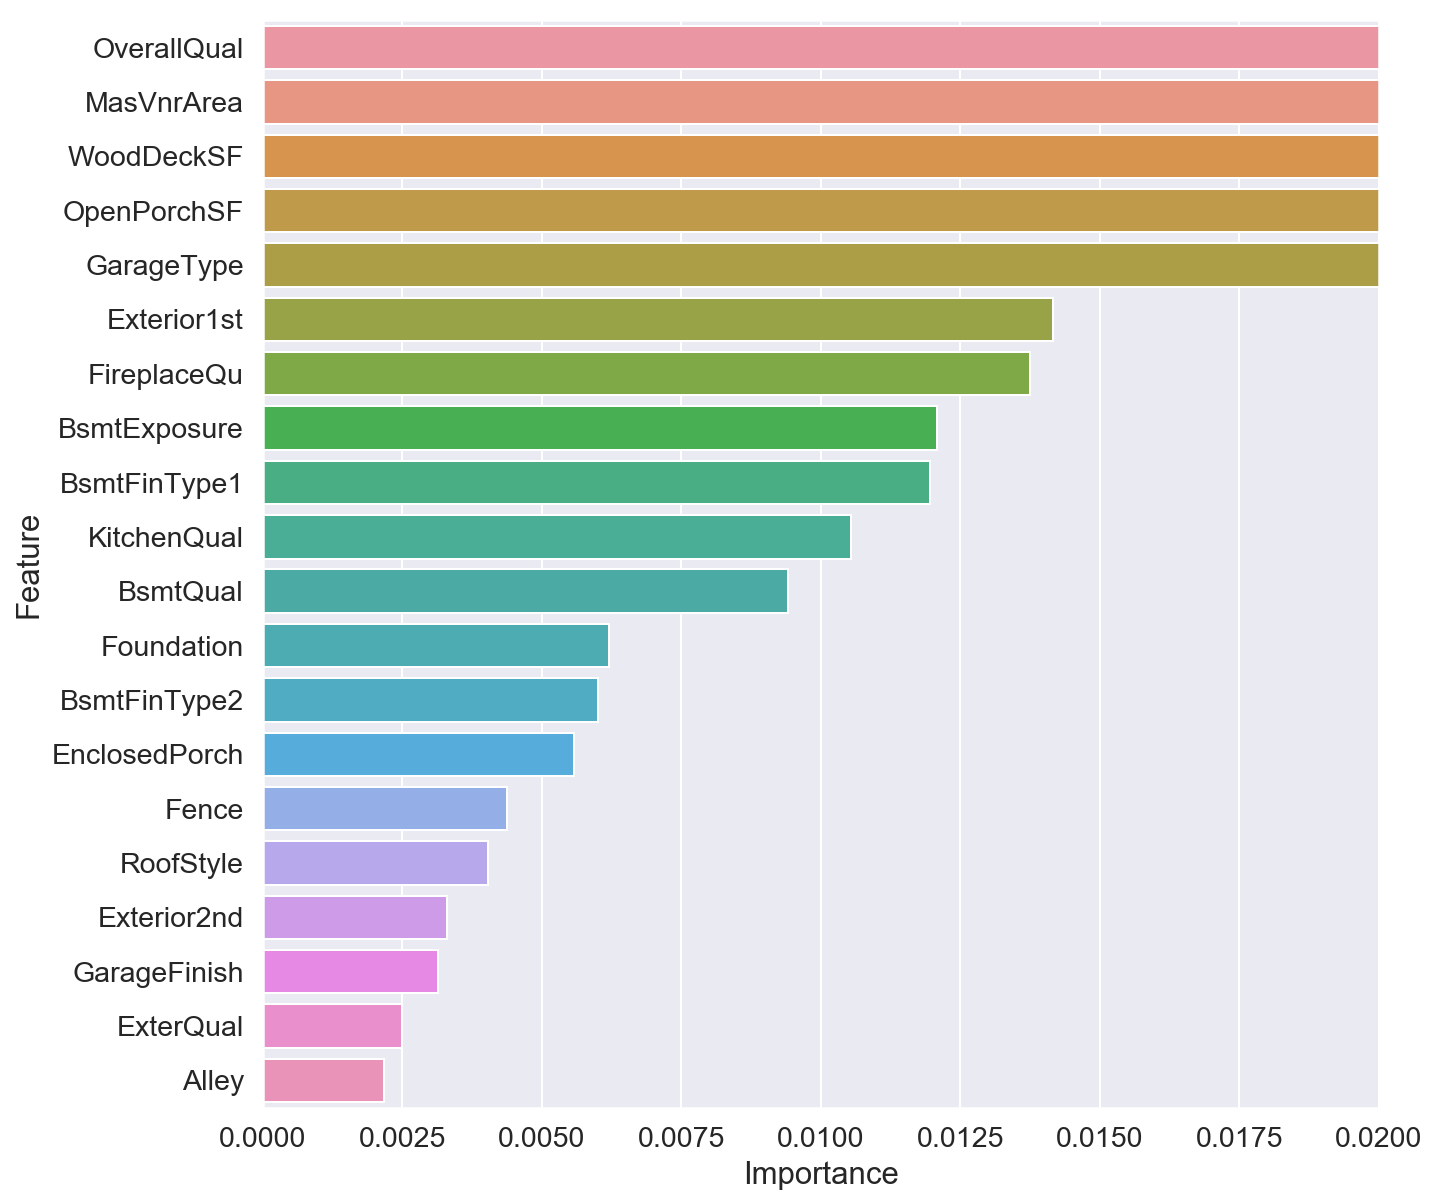

In [68]:
feature_selectionr = pd.DataFrame(Xr.columns, columns = ['Feature'])
feature_selectionr['Importance'] = feature_importancesr
feature_selectionr.sort_values(by = 'Importance', ascending = False, inplace = True)
feature_selectionr.reset_index(drop = True, inplace = True)
fsr = feature_selectionr.head(20)

sns.set(rc={'figure.figsize': (10,10)}, font_scale=1.3)
sns.barplot(x = 'Importance', y = 'Feature', data = fsr)
plt.xlim(0,0.02)

In [69]:
feature_selectionr.head()

Feature  Importance
0  OverallQual    0.733006
1   MasVnrArea    0.045957
2   WoodDeckSF    0.042639
3  OpenPorchSF    0.033538
4   GarageType    0.029989

**Combine the Selected Renovatable Features with the Fixed Features from Model 1**

In [70]:
# Removed due to no effect of importance: 'Fence','Alley','GarageYrBlt','Foundation','GarageQual','GarageCond','BsmtFinType1','BsmtFinType2','ExterQual','BsmtCond', 
# 'BsmtCond', 'RoofStyle', 'LotShape'

holdr = res_homes[['SalePrice', 'YrSold']]

for_stdr = res_homes[['OverallQual','MasVnrArea','WoodDeckSF','OpenPorchSF', 'HalfBath','home_age','home_size']]

for_dummiesr = res_homes[['GarageType','GarageFinish', 'BsmtExposure', 'BsmtQual',
                          'Exterior1st','Exterior2nd','ExterCond',
                          'FireplaceQu','KitchenQual',
                         'Neighborhood','MSZoning','BldgType','HouseStyle','MSSubClass']]

#standardizing using RobustScaler
scaler = RobustScaler()
scaler.fit(for_stdr)
stdr = scaler.transform(for_stdr)

#Label encoding for the decision tree 
le = preprocessing.LabelEncoder()
X_dumr = for_dummiesr.apply(LabelEncoder().fit_transform)

#Return the transformed values to a DataFrame
X_numr = pd.DataFrame(stdr, columns = for_stdr.columns)
datar = pd.concat([holdr, X_numr, X_dumr], axis = 1)

# Training data is only using the pre 2010 housing data
trainr = datar[datar['YrSold'] < 2010]

# Separate into target and predictors
Xr = trainr.drop(columns = ['SalePrice', 'YrSold'])
yr = trainr['SalePrice'].values

In [71]:
classifier = DecisionTreeClassifier(criterion='gini',max_depth=None)
regressorr = DecisionTreeRegressor(criterion='mse',max_depth=10)
regressorr.fit(Xr, yr)
feature_importancesr = regressorr.feature_importances_

(0, 0.02)

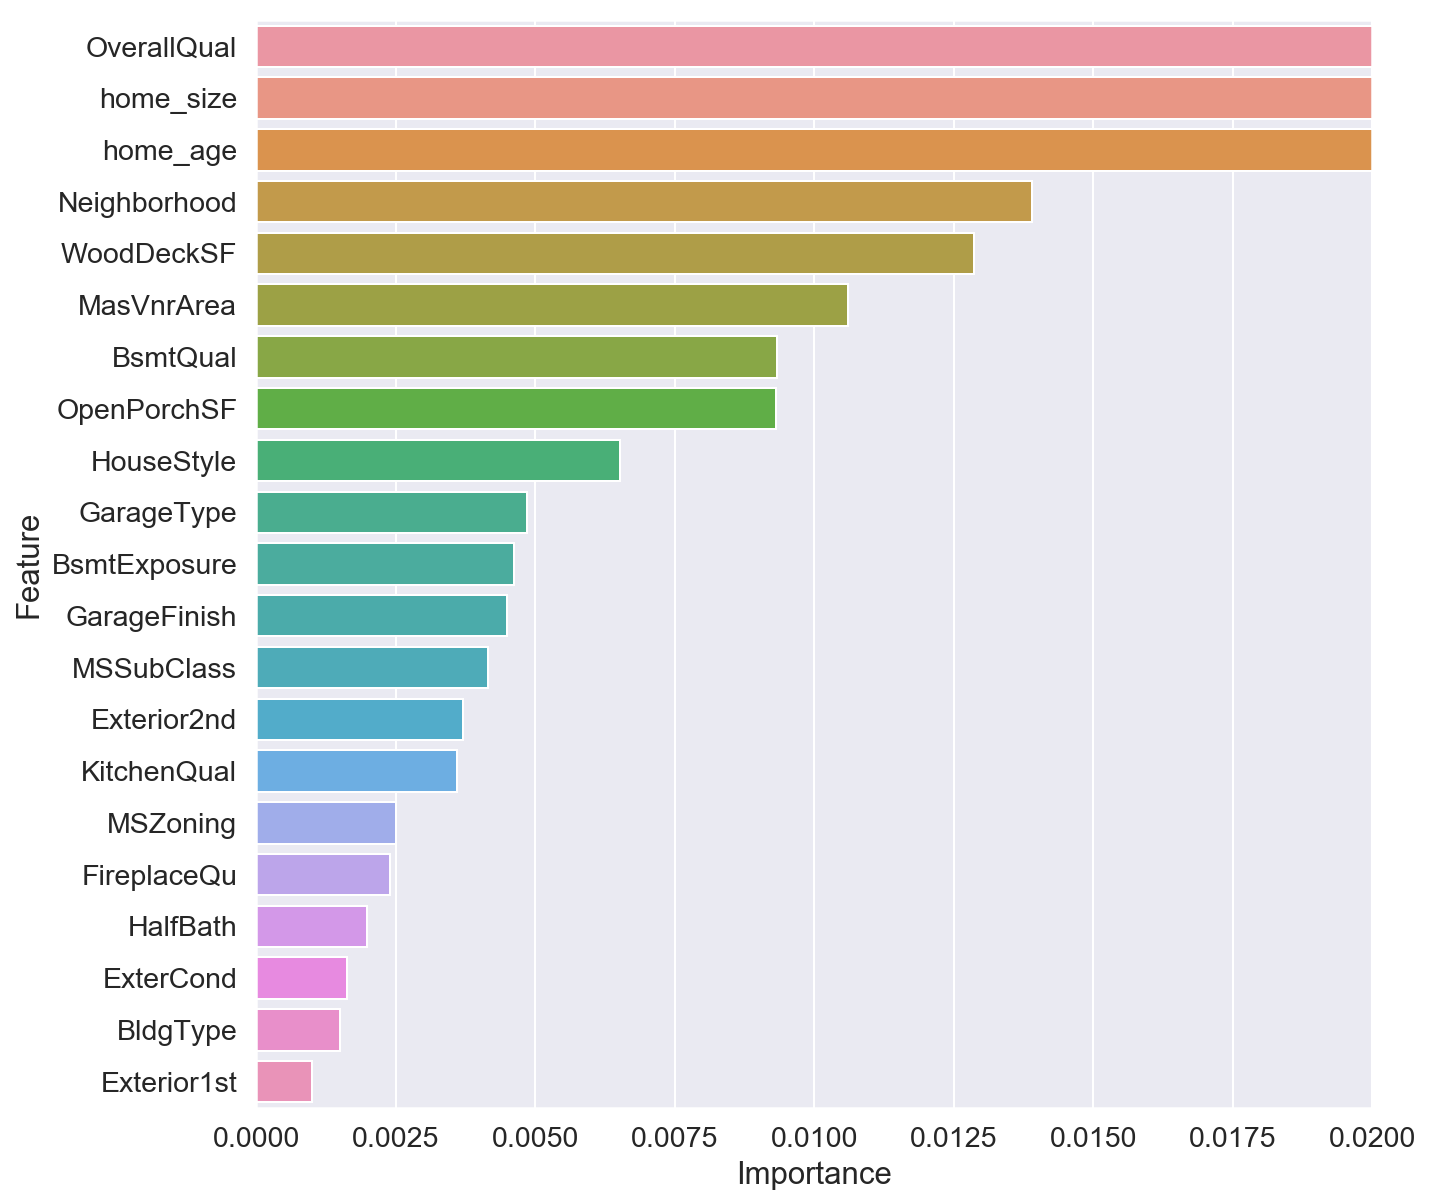

In [72]:
feature_selectionr = pd.DataFrame(Xr.columns, columns = ['Feature'])
feature_selectionr['Importance'] = feature_importancesr
feature_selectionr.sort_values(by = 'Importance', ascending = False, inplace = True)
feature_selectionr.reset_index(drop = True, inplace = True)
fsr = feature_selectionr
sns.barplot(x = 'Importance', y = 'Feature', data = fsr)
plt.xlim(0,0.02)

In [73]:
feature_selectionr.head()

Feature  Importance
0   OverallQual    0.551958
1     home_size    0.320209
2      home_age    0.028903
3  Neighborhood    0.013911
4    WoodDeckSF    0.012864

In [74]:
# Get dummies for Linear Regression Model
X_dumr = pd.get_dummies(for_dummiesr, drop_first=True)

# New DataFrame of dummies and scaled features
X_numr = pd.DataFrame(stdr, columns = for_stdr.columns)
X_dumr.reset_index(drop = True, inplace = True)
datar = pd.concat([holdr, X_numr, X_dumr], axis = 1)

# Training data is only using the pre 2010 housing data
trainr = datar[datar['YrSold'] < 2010]

# Separate into target and predictors
Xr = trainr.drop(columns = ['SalePrice', 'YrSold'])
yr = trainr['SalePrice'].values

In [75]:
# Train and test sets for the model
X_trainr, X_testr, y_trainr, y_testr = train_test_split(Xr.values, yr, test_size=0.20)

In [76]:
# RidgeCV performs best compared to LassoCV and ElasticNetCV

alpha = np.logspace(-0.001, 10, 500)
kf = KFold(10, random_state=42).get_n_splits(X_trainr)
ridger = RidgeCV(alphas=alphas, cv = kf, scoring = 'r2')
ridger= ridger.fit(X_trainr, y_trainr)

print('Training Specs ---------')
print(ridger)
print('Best Alpha:', ridger.alpha_)
print('Intercept:',  ridger.intercept_)
y_predictr = ridger.predict(X_testr)
print('R2:',r2_score(y_testr, y_predictr))
print('RMSE:',np.sqrt(mean_squared_error(y_testr, y_predictr)))

Training Specs ---------
RidgeCV(alphas=array([9.97700e-01, 1.04482e+00, ..., 9.54900e+09, 1.00000e+10]),
    cv=10, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='r2', store_cv_values=False)
Best Alpha: 5.502462788449709
Intercept: 231564.71603841975
R2: 0.857828360289159
RMSE: 27125.352735647215


In [77]:
# Extracting Values of from the cross validation using kfold
kf = KFold(10, random_state=42).get_n_splits(X_trainr)
scores = cross_val_score(ridger, X_trainr, y_trainr, scoring="r2", cv = kf)
print('R2 scores for 10 cv', scores)
print('Mean R2 Scores:', np.mean(scores))
print('Std R2 Scores:', np.std(scores))

R2 scores for 10 cv [0.87993564 0.87813995 0.80126406 0.84248114 0.88116309 0.900846
 0.89616029 0.90155725 0.88861708 0.89994791]
Mean R2 Scores: 0.8770112417751308
Std R2 Scores: 0.030257398495980775


**The Model has an even better mean R2 value and a lower RMSE compared to fixed features only**

**The Model is also very stable as seem from the 10x cross validation scores**

### Predicting Sale Prices for the homes in 2010

In [81]:
holdr = datar[datar['YrSold'] >= 2010]
X_2010r = holdr.drop(columns = ['SalePrice', 'YrSold'])
y_2010r = holdr['SalePrice'].values 

#Predicted Score of 2010 Homes using both Renovatable and Fixed Features
y_predicted_2010r = ridger.predict(X_2010r.values)
print('R2:',r2_score(y_2010r, y_predicted_2010r))
print('RMSE:',np.sqrt(mean_squared_error(y_2010r, y_predicted_2010r)))

R2: 0.8820433649828149
RMSE: 27801.47707852853


In [82]:
predictions = pd.DataFrame(y_2010, columns =['True_Sale_Price'])
predictions['Model1_predicted_Sale_Price'] = y_predicted_2010
predictions['Model2_predicted_Sale_Price'] = y_predicted_2010r

Text(0.5, 12.847999999999978, 'Predicted Prices Model 2')

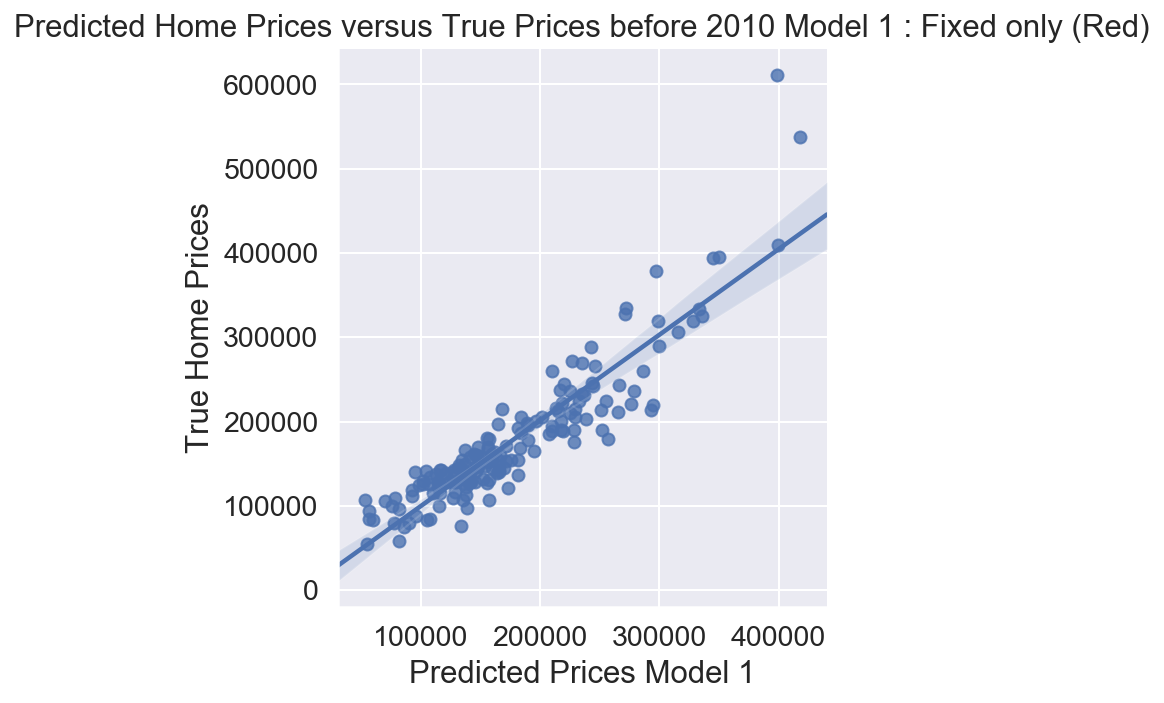

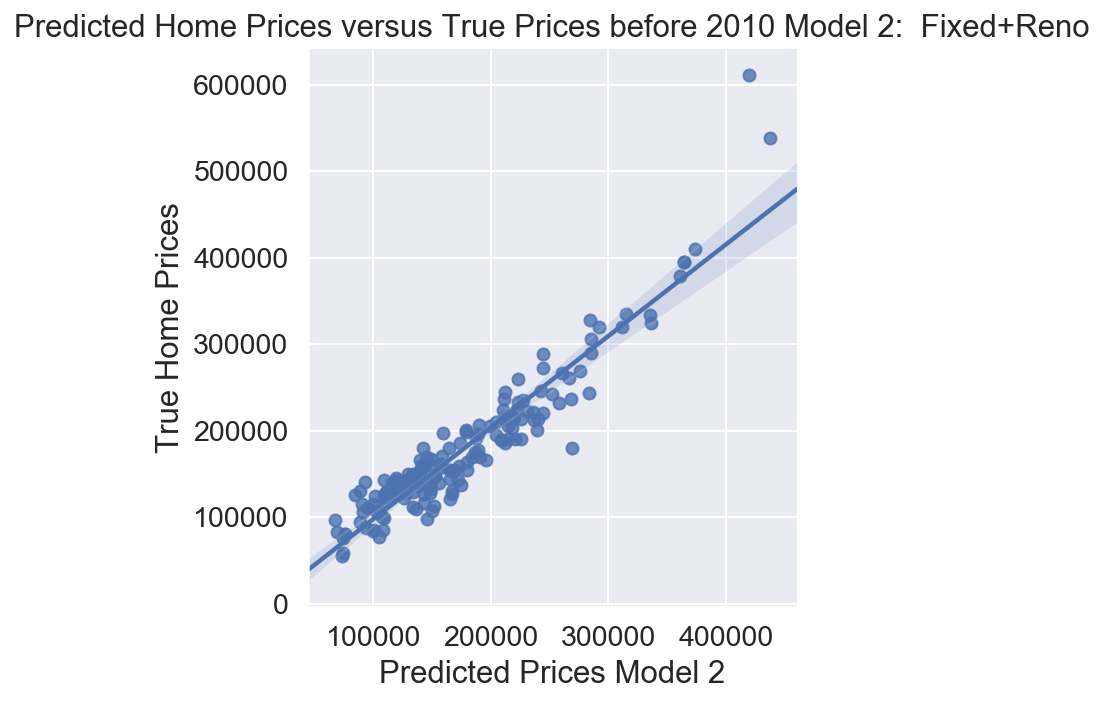

In [83]:
#Model 1 versus 2, 2010 values.
ax1 = sns.lmplot(x = 'Model1_predicted_Sale_Price', y = 'True_Sale_Price', data = predictions)
plt.title('Predicted Home Prices versus True Prices before 2010 Model 1 : Fixed only (Red)')
plt.ylabel('True Home Prices')
plt.xlabel('Predicted Prices Model 1')

ax1 = sns.lmplot(x = 'Model2_predicted_Sale_Price', y = 'True_Sale_Price', data = predictions)
plt.title('Predicted Home Prices versus True Prices before 2010 Model 2:  Fixed+Reno')
plt.ylabel('True Home Prices')
plt.xlabel('Predicted Prices Model 2')

**3 Properties are still not accurately predicted by Model 2, there properties may be outliers.**
**Model 2 overall is better than Model 1 overall and reduces the error**

### How much of the variance in the first model can be explained by the second model?
**i.e How much of the Sale Price is accounted by the renovations on average?**

1) We can substract the residuals of the second model from the residuals of the second model (y_pred - y_true)

2) We can substract the RMSE of second model from RMSE of the first model

**1) Comparing residuals**

In [84]:
# Model 1 = ridge with data
# Model 2 = ridgef with dataf

X_mod1 = data.drop(columns = ['SalePrice', 'YrSold'])
y_mod1 = data['SalePrice'].values

X_mod2 = datar.drop(columns = ['SalePrice', 'YrSold'])
y_mod2 = datar['SalePrice'].values

y_pred_model1 = ridge.predict(X_mod1)

y_pred_model2 = ridger.predict(X_mod2)

In [85]:
res_mod1 = np.abs(y_pred_model1 - y_mod1)
res_mod2 = np.abs(y_pred_model2 - y_mod2)

In [86]:
residuals = pd.DataFrame(res_mod1, columns = ['Model_1_Residuals'])
residuals['Model_2_Residuals'] = res_mod2
residuals['Difference_in_Residuals'] = residuals['Model_2_Residuals'] - residuals['Model_1_Residuals']
residuals.mean()

Model_1_Residuals          22508.86290
Model_2_Residuals          17871.28279
Difference_in_Residuals    -4637.58011
dtype: float64

**2) Comparing RMSE**

In [87]:
rmse1 = round(np.sqrt(mean_squared_error(y_2010, y_predicted_2010)),2)
rmse2 = round(np.sqrt(mean_squared_error(y_2010r, y_predicted_2010r)),2)
print('RMSE Model 1: $',rmse1)
print('RMSE Model 2: $ ', rmse2)
print('Difference in RMSE: $', round((rmse2 -rmse1),2))

RMSE Model 1: $ 33576.47
RMSE Model 2: $  27801.48
Difference in RMSE: $ -5774.99


**The Renovations can account between $4000 - 6000 of the SalePrice**

**Therefore the fixed features are better predictors of price, but the sale price increases the precision of the model and the cost of the home on average**

### What are the strongest Sale Price predictors ?

**The Strongest Predictors of Home Price are the Home Size, Home age and the Overall Quality of the home**

### What is the value added by the renovations ? 

In [88]:
coef_list =[tuple(ridger.coef_)]
coefs = pd.DataFrame(coef_list, columns = Xr.columns, index = ['Dollar Value ($)'])

In [89]:
# Reversing the Standardardization of the Home age and the Home Size 
# Equation = Feature Coefficient / Standard deviation of the Feature
coefs[['OverallQual','MasVnrArea', 'WoodDeckSF', 'OpenPorchSF', 'HalfBath', 'home_age','home_size']]= scaler.transform(coefs[['OverallQual','MasVnrArea', 'WoodDeckSF', 'OpenPorchSF', 'HalfBath', 'home_age','home_size']])

In [90]:
# Features with the most Dollar Values (negative and positive)
dollar_values = pd.DataFrame(coefs.values[0].tolist(), columns = ['Dollar_Value_($)'], index = Xr.columns)
dollar_values = dollar_values.apply(lambda x: round(x,2))
print('Features That Increase Home Prices the Most')
print(dollar_values.sort_values(by = 'Dollar_Value_($)', ascending = False).head(10))
print('-----------------------------------------------------------------')
print('Features That Decrease Home Prices the Most')
print(dollar_values.sort_values(by = 'Dollar_Value_($)', ascending = False).tail(10))
print('-----------------------------------------------------------------')
print('Value per unit added (unit of quality, sqft, per bathroom or age)')
print(dollar_values.head(7))

Features That Increase Home Prices the Most
                      Dollar_Value_($)
Neighborhood_StoneBr          32880.12
Neighborhood_NoRidge          23017.17
Neighborhood_Crawfor          20195.57
BsmtExposure_Gd               19080.46
HouseStyle_2.5Fin             18713.02
Neighborhood_NridgHt          15487.28
Exterior1st_BrkFace           15358.40
GarageType_BuiltIn            13802.29
OverallQual                   11587.98
BldgType_2fmCon               10985.58
-----------------------------------------------------------------
Features That Decrease Home Prices the Most
                     Dollar_Value_($)
BsmtExposure_No              -9089.63
Neighborhood_NWAmes         -10411.27
BldgType_Twnhs              -12046.60
BldgType_Duplex             -15716.28
KitchenQual_Gd              -17834.89
KitchenQual_Fa              -19630.28
BsmtQual_Fa                 -21559.56
BsmtQual_TA                 -23375.19
BsmtQual_Gd                 -24297.04
KitchenQual_TA              -25280.95

## How much returns would we get from renovating a home ??

Two of the easiest features that increase value are the Porch and Deck. The other that increase the price is the exposure of the basement. 

Let's assume we purchase a home with no Open Porch and no exposure in the basement (but has a basement which has a score of Unf to BLQ)

1) A Basement walkout is a major renovation and requires a lot of cost. Our house will have a Minimum exposure basement, therefore the foundation is there and requires only upgrades, staircase and door. This would cost under 20k to build. 

2) We want to also build a porch. The size of the Open Porch is between 4 and 547 sqft, with a mean of 81 sqft. For the purpose of this project, we will build a 200 sqft porch. This is around $25 per sqft. 



1) pick a home with the attributes we are looking for:
    - has a basement
    - has no walkout (Bsmt exposure = no exposure to minimum exposure)
    - no porch or Deck

In [91]:
datar[(datar['OpenPorchSF'] == 0) & (datar['WoodDeckSF'] == 0)][['SalePrice', 'YrSold','WoodDeckSF','OpenPorchSF','BsmtExposure_None','BsmtExposure_No','BsmtExposure_Mn','BsmtExposure_Gd','BsmtQual_Fa','BsmtQual_Gd','BsmtQual_None','BsmtQual_TA']]

SalePrice  YrSold  WoodDeckSF  OpenPorchSF  BsmtExposure_None  \
66       225000    2006         0.0          0.0                  0   
1091     218000    2007         0.0          0.0                  0   

      BsmtExposure_No  BsmtExposure_Mn  BsmtExposure_Gd  BsmtQual_Fa  \
66                  1                0                0            0   
1091                0                0                1            0   

      BsmtQual_Gd  BsmtQual_None  BsmtQual_TA  
66              0              0            1  
1091            1              0            0

**2) House 66 has a basement with a fair basement quality (70-79 sqft) and does not have a wood deck of an open porch. Let's say we were the ones who  purchase it in 2006 and we will now sell it in 2010.**

**SalePrice = $225000**

**3) How much would we sell this house without the renovations in 2010 ?**

In [92]:
# Model Accuracy price prediction 2006
mod_ac =  datar[datar.index == 66].drop(columns = ['SalePrice', 'YrSold'])
ac = ridger.predict(mod_ac)
print('Sale Price with No Renovations in 2010: $',np.round(ac[0],2))

Sale Price with No Renovations in 2010: $ 226826.76


**The Model is very accurate at predicting the price of this home**

In [93]:
# Selcted home with 4 more years (purchased in 2006)
basic = datar[datar.index == 66].drop(columns = ['SalePrice', 'YrSold'])
basic.loc[:,'home_age'] = 0.43

In [94]:
no_renos = ridger.predict(basic)
print('Sale Price with No Renovations in 2010: $',np.round(no_renos[0],2))

Sale Price with No Renovations in 2010: $ 225764.32


**4) How much would we sell this house with the renovations in 2010**

In [95]:
renovated = datar[datar.index == 66].drop(columns = ['SalePrice', 'YrSold'])
renovated.loc[:,'home_age'] = 0.43
renovated.loc[:,'BsmtExposure_Gd'] = 1
renovated.loc[:,'OpenPorchSF'] = 2.86

In [96]:
with_renos = ridger.predict(renovated)
print('Sale Price with No Renovations in 2010: $',np.round(with_renos[0],2))

Sale Price with No Renovations in 2010: $ 256361.9


**Profits or loss?**

In [97]:
cost_deck = 200*25 #200$ per sqft of deck
print('-----------------------------------')
print('Price of renovations:')
print('200 Sqft of Deck at 25$/sqft = $', cost_deck)
print('Good Exposure Basement = $ 15,000')
print('Total Renovations cost =$', (15000 + cost_deck))
print('-----------------------------------')
print('Profit or Loss:')
print('Sale Price 2010 - Purchase Price 2006: $', round((222406.09 - 225000),2))
print('Sale Price 2010 + Renos - Purchase Price 2006 - Renovation Costs: $', round((262376.35 - 225000 - (15000+cost_deck)),2))

-----------------------------------
Price of renovations:
200 Sqft of Deck at 25$/sqft = $ 5000
Good Exposure Basement = $ 15,000
Total Renovations cost =$ 20000
-----------------------------------
Profit or Loss:
Sale Price 2010 - Purchase Price 2006: $ -2593.91
Sale Price 2010 + Renos - Purchase Price 2006 - Renovation Costs: $ 17376.35


**Are the Renovations worth it ?**

- Yes, although we had to put a substantial amount of money at first to renovate ($20,000), the renovations of the basement and the deck are worth it. 
- Due to the post 2008 market, selling a house that was purchased in 2006 would be sold at a loss without the renovations. With the renovations, you could make a profit equal to your cost (i.e revenue = 2x cost)

**Is the Model Accurate and Reliable?**

- The model is fairly accurate at predicting home prices for 2010 sales, with an R2 value of .88 and a RMSE of $22,000.
- The downside is that it requires several Features to predict an accurate price, which includes both the fixed and renovatable features. 
- The model could be even more accurate with a log transformed Sale Price. This would correct for the skew of the SalePrices, but it would also increase the complexity and decrease the usability of the model. 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

Text(0, 0.5, 'Frequency')

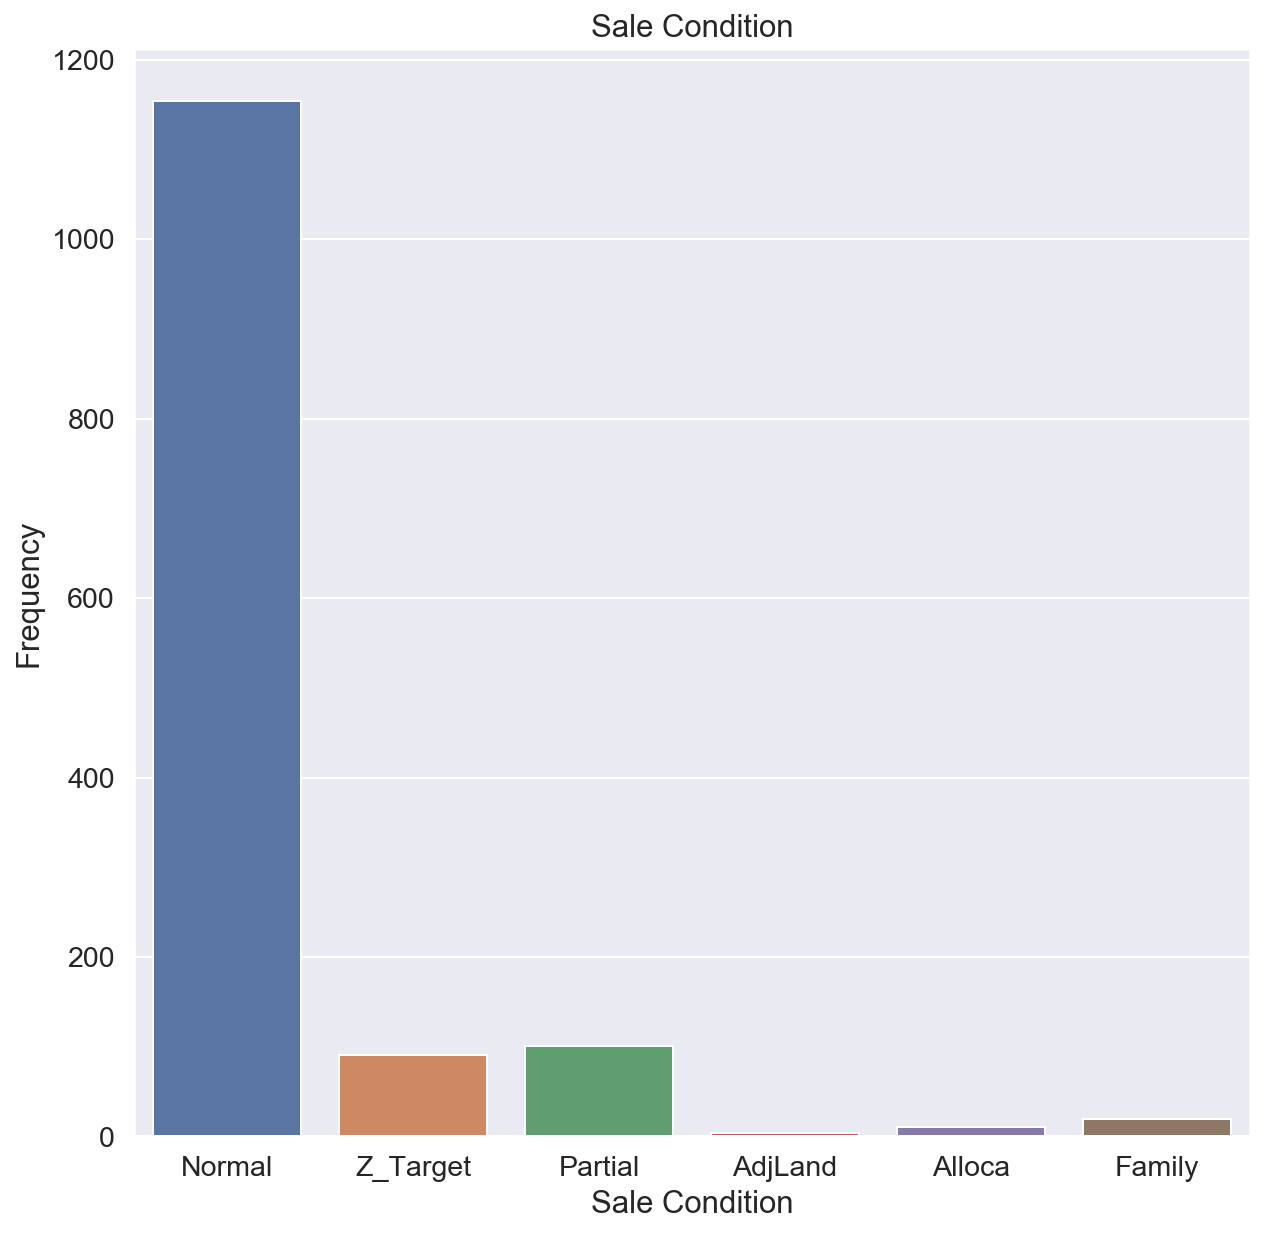

In [98]:
#Target
res_homes['SaleCondition'] = res_homes['SaleCondition'].replace('Abnorml', 'Z_Target')
y = res_homes[['SaleCondition']]
sns.countplot(x = 'SaleCondition', data = y)
plt.title('Sale Condition')
plt.xlabel('Sale Condition')
plt.ylabel('Frequency')

**The categories are not balanced**

**Note: There are no abnormal sales in the 2010 dataset. Use train test split on who dataset instead**

In [128]:
# Categories that do not add essential information or that give redundant informtion. 
X = res_homes.drop(columns = ['SaleCondition', 'MoSold', 'YrSold', 'YearBuilt', 'Id', 'Street', 'Heating', '1stFlrSF', '2ndFlrSF','RoofMatl', 'TotalBsmtSF', 'GarageYrBlt'])

#Standardize numerical values 
X_numerical = X.select_dtypes(exclude=['object'])
scaling = RobustScaler()
X_scaled = pd.DataFrame(scaling.fit_transform(X_numerical), columns = X_numerical.columns)

#LabelEncoder for Categorical Values
X_categorical = X.select_dtypes(include=['object'])
X_labeled = X_categorical.apply(LabelEncoder().fit_transform)
X_labeled.reset_index(drop = True, inplace = True)

In [129]:
#Dataframe with all X values 
X_values = pd.concat([X_scaled, X_labeled], axis = 1)
X = X_values.values

# The number 5 is the Abnormal Sale
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [161]:
# Balance through Random OverSampling
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.3)
print('Train set Y Sample Size', Counter(y_train))

Train set Y Sample Size Counter({3: 829, 1: 813, 5: 811, 0: 802, 2: 799, 4: 792})


In [162]:
print('Test set Y Sample Size', Counter(y_test))

Test set Y Sample Size Counter({4: 362, 2: 355, 0: 352, 5: 343, 1: 341, 3: 325})


**Using AdaBoost + Decision Tree Classifier**

In [163]:
#Identify best predictors using adaboost and decision tree

parameters = {'max_depth':np.linspace(1,50), 'criterion' :['gini', 'entropy'], 'class_weight':['balanced']}
DT =  RandomForestClassifier()
clf = GridSearchCV(DT, parameters, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]), 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=

In [164]:
clf.best_params_ 

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20.0}

In [165]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20, class_weight = 'balanced', criterion = 'entropy'),n_estimators=300)
ada_fit = ada.fit(X_train, y_train)
                 
print('Mean CV score:', cross_val_score(ada_fit,X_train, y_train, cv=10))

Mean CV score: [0.97745902 0.96919918 0.98350515 0.96487603 0.96694215 0.98553719
 0.97520661 0.95661157 0.98553719 0.97095436]


In [166]:
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, recall_score, classification_report
y_pred = ada_fit.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[352,   0,   0,   0,   0,   0],
       [  0, 341,   0,   0,   0,   0],
       [  0,   0, 355,   0,   0,   0],
       [  2,   2,  15, 295,   0,  11],
       [  0,   0,   0,   0, 362,   0],
       [  0,   0,   0,   0,   0, 343]], dtype=int64)

**Can we get better ??**

In [186]:

parameters = {
    'bootstrap': [True],
    'max_depth': [10, 50, 100, 200],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}

rf = RandomForestClassifier()
gs = GridSearchCV(rf, parameters, cv = 3, n_jobs = -1, verbose = 2)
gs.fit(X_train,y_train)


Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 10.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [10, 50, 100, 200], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [187]:
gs.best_params_ 

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [ ]:
# From gridsearch : Parameters were found. 
rf = RandomForestClassifier(bootstrap = True,max_depth =100,max_features= 3,min_samples_leaf= 3,min_samples_split= 8,n_estimators =1000,n_jobs=-1)
bclf = AdaBoostClassifier(base_estimator=rf,n_estimators=rf.n_estimators)
bclf = bclf.fit(X_train,y_train)
y_pred = bclf.predict(X_test)

print('Mean CV score:', cross_val_score(bclf,X_train, y_train, cv=10))
print('Confusion Matrix Adaboost Random Forest:', confusion_matrix(y_test, y_pred))

In [173]:
gb = GradientBoostingClassifier(n_estimators=1000)
gb = gb.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Mean CV score:', cross_val_score(gb,X_train, y_train, cv=10))
print('Confusion Matrix Gradient Boosting:', confusion_matrix(y_test, y_pred)

array([[352,   0,   0,   0,   0,   0],
       [  0, 341,   0,   0,   0,   0],
       [  0,   0, 355,   0,   0,   0],
       [  1,   0,   6, 295,   1,  22],
       [  0,   0,   0,   0, 362,   0],
       [  0,   0,   0,  10,   0, 333]], dtype=int64)

In [175]:
ada_fit.feature_importances_

array([3.63065117e-02, 1.84350583e-02, 1.06166317e-02, 1.40524436e-03,
       1.41798161e-03, 2.12194434e-02, 2.04069700e-01, 1.09942332e-02,
       8.47445894e-04, 5.84256641e-02, 0.00000000e+00, 0.00000000e+00,
       8.68269376e-02, 3.76735901e-03, 0.00000000e+00, 4.63147826e-04,
       0.00000000e+00, 8.49152118e-04, 3.58167883e-02, 3.96538519e-03,
       2.22993507e-03, 2.21492662e-04, 1.60430280e-01, 1.58412724e-03,
       7.31827473e-03, 2.57265126e-03, 0.00000000e+00, 2.06879563e-03,
       0.00000000e+00, 1.30041252e-04, 2.80500012e-02, 1.30756391e-01,
       1.11253610e-02, 7.82363413e-04, 0.00000000e+00, 1.83220600e-03,
       9.12477398e-04, 0.00000000e+00, 4.82189888e-04, 0.00000000e+00,
       6.85290175e-03, 8.14314183e-04, 0.00000000e+00, 2.33332261e-04,
       7.02884015e-05, 5.72111247e-03, 1.60728149e-02, 1.93688525e-03,
       8.94014769e-03, 2.29541879e-04, 1.73139278e-04, 1.54107801e-03,
       2.95506087e-03, 2.13239977e-04, 9.24080914e-03, 1.09556457e-02,
      

Text(0.5, 1.0, 'Feature Importance Using AdaBoost and DecisionTree')

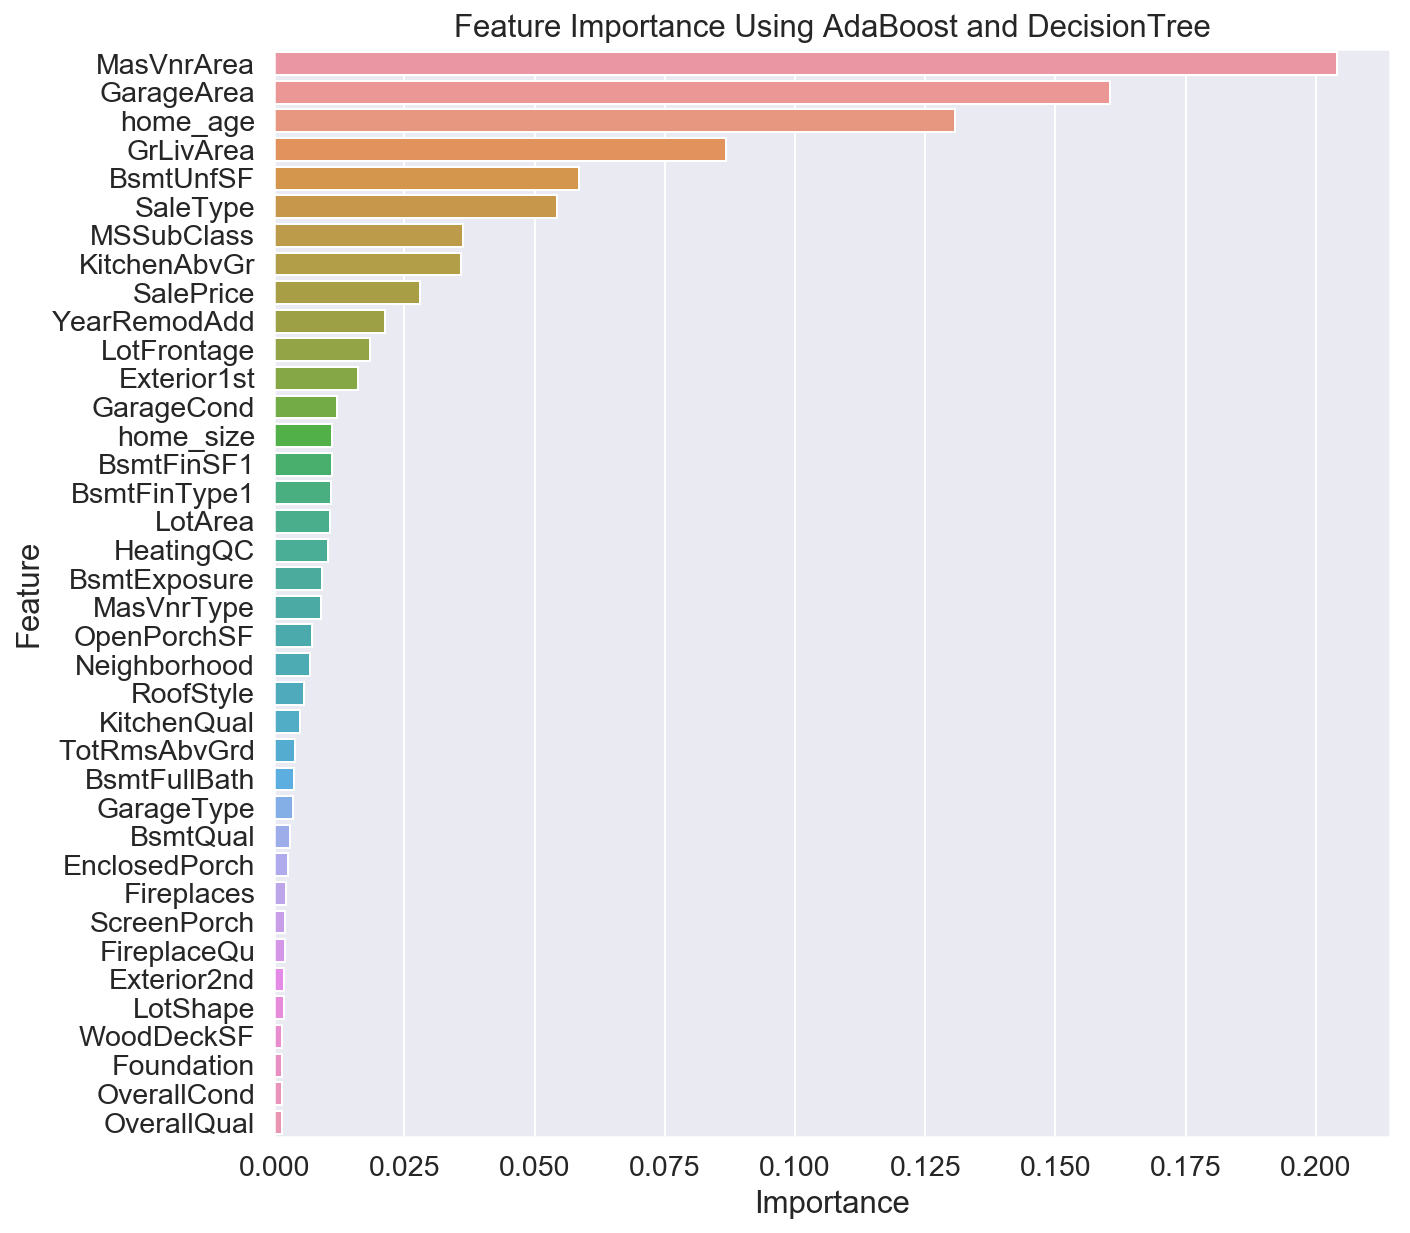

In [177]:
importances = pd.DataFrame(ada_fit.feature_importances_, columns = ['Importance'])
importances['Feature'] = X_values.columns
imp = importances[importances['Importance'] > 0.001].sort_values(by = 'Importance', ascending = False)

sns.set(rc={'figure.figsize': (10,10)}, font_scale=1.3)
sns.barplot(x = 'Importance', y = 'Feature', data = imp)
plt.title('Feature Importance Using AdaBoost and DecisionTree')